# Расследование причин убытков приложения Ridiculous Sample

<br>

## Введение

**Описание проекта**

Развлекательное приложение `Ridiculous Sample`, у которого есть проблема: несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

<br>

**Цель и задачи**

<span style='font-weight: 600'>Цель.</span>\
Нужно разобраться в причинах убытков и помочь компании выйти в плюс.

<span style='font-weight: 600'>Задачи:</span>
* из каких источников приходят пользователи, какими устройствами пользуются, из каких они стран;
* сколько стоит привлечение пользователей из различных рекламных каналов;
* провести когортный анализ:
    * вычислить <span style='font-weight: 600'>RR</span> и <span style='font-weight: 600'>CR</span> пользователей;
    * рассчитать юнит-экономику: <span style='font-weight: 600'>LTV</span>, <span style='font-weight: 600'>CAC</span>, <span style='font-weight: 600'>ROI</span>.
* разобраться:
    * когда расходы на привлечение клиента окупаются;
    * какие факторы мешают привлечению клиентов;
* дать рекомендации отделу маркетинга, чтобы реклама начала приносить прибыль.

<br>

**Данные**\
Предоставлены следующие данные о пользователях, привлечённых с $1$ мая по $27$ октября $2019$ года:
* `visits.csv` — посещения сайта;
* `orders.csv` — заказы;
* `costs` — рекламные расходы.

<br>

**План действия**
1. Загрузить данные и подготовить их к анализу.
2. Задать функции для расчёта и анализа LTV, CAC, ROI, удержания и конверсии.
3. Провести исследовательский анализ данных.
4. Изучить маркетинг.
5. Провести когортный анализ:
    1. проанализировать удержание и конверсию;
    2. рассчитать юнит-экономику;
    3. выяснить, что мешает окупаемости пользователей;
    4. дать решение проблемы.
6. Сделать выводы.

<br>

## Подготовка

<span style="font-weight: 600">Подготовим почву для работы: импортируем библиотеки, зададим опции для вывода данных, прочитаем данные и запишем их в переменные.<span>

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# все назойливые предупреждения будут игнорироваться
import warnings
warnings.filterwarnings('ignore')

# задание опций и стилей
# отображение неограниченного количества колонок в выводе
pd.set_option('display.max_columns', None)
# отображение первых и последних 3 строк
pd.set_option('display.min_rows', 6)

<br>

Прочитаем данные.

In [2]:
# посещения сайта
visits = pd.read_csv('https://drive.usercontent.google.com/download?id=1hS_Ew2FUJJiDK4Fm4ZjP5pndagCfGQJq&export=download&authuser=0&confirm=t&uuid=0c43de50-056f-410a-9bdf-e40633160c98&at=AO7h07d9bzYS1pO1FyVTHsLLqnid:1726153558792')
# заказы
orders = pd.read_csv('https://drive.usercontent.google.com/download?id=1dcNak5jMZZeNk6lbaZjF_nzbIuZlMku9&export=download&authuser=0&confirm=t&uuid=5ae64c63-838c-492f-8e2d-82ca54302c9a&at=AO7h07dxzzK9_BpYC4GBdMQ1hauJ:1726153519317')
# затраты на рекламу
costs = pd.read_csv('https://drive.usercontent.google.com/download?id=11-za7EP2pmO8j5gWXeUHzaYt-uGVUTxg&export=download&authuser=0&confirm=t&uuid=669b73fe-b9f8-4623-8fea-b4cbc554eb61&at=AO7h07ccx15brv2pijo4jM4H3_uF:1726153499179')

<br>

<br>

## Обзор и обработка данных

##### Ознакомимся с каждой таблицей. Проведём их обработку, если нужно

Сделаем функцию для обзора таблиц.

In [3]:
# функция для обзора таблиц
def obs_df(df, name):
    print('')
    print(name)
    print('')
    display(df)
    print('\n')
    print('Информация о таблице')
    print('')
    print(df.info())
    print('\n')
    print('Информация о пропусках')
    display(pd.concat([df.isna().mean() * 100, df.isna().sum()], axis=1)\
      .rename(columns={0: '% пропусков',
                       1: 'Пропусков'}))
    print('\n')
    print(f'Кол-во явных дублей: {df.duplicated().sum()}')
    print('')
    print(f'Кол-во строк: {df.shape[0]}')
    print(f'Кол-во колонок: {df.shape[1]}')
    print('')

<br>

### Таблица с посещениями

In [4]:
obs_df(visits, 'Таблица с посещениями')


Таблица с посещениями



User Id         Region  Device    Channel        Session Start  \
0       981449118918  United States  iPhone    organic  2019-05-01 02:36:01   
1       278965908054  United States  iPhone    organic  2019-05-01 04:46:31   
2       590706206550  United States     Mac    organic  2019-05-01 14:09:25   
...              ...            ...     ...        ...                  ...   
309898  540102010126        Germany      PC    organic  2019-10-31 01:40:48   
309899  308736936846        Germany     Mac    organic  2019-10-31 07:37:34   
309900  109329042535        Germany      PC  lambdaAds  2019-10-31 14:17:43   

                Session End  
0       2019-05-01 02:45:01  
1       2019-05-01 04:47:35  
2       2019-05-01 15:32:08  
...                     ...  
309898  2019-10-31 01:41:31  
309899  2019-10-31 07:37:55  
309900  2019-10-31 15:17:04  

[309901 rows x 6 columns]



Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


Информация о пропусках


% пропусков  Пропусков
User Id                0.0          0
Region                 0.0          0
Device                 0.0          0
Channel                0.0          0
Session Start          0.0          0
Session End            0.0          0



Кол-во явных дублей: 0

Кол-во строк: 309901
Кол-во колонок: 6



Имеем $309$ $901$ строк и $6$ колонок.\
В таблице с посещениями предстоит провести предобработку данных: переименовать все колонки, привести колонки с датой к верному типу данных.\
Пропусков и дублей не наблюдается.

<br>

Дадим колонкам корректные названия.

In [5]:
# приведём колонки к нижнему регистру
visits.columns = visits.columns.str.lower()

# переименуем некоторые из них
visits = visits.rename(columns={'user id': 'user_id',
                                'session start': 'session_start',
                                'session end': 'session_end'})

<br>

Поменяем типы данных в колонках с датами.

In [6]:
# смена типа на datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

<br>

Посмотрим числовое описание данных.

In [7]:
visits.describe()

user_id                  session_start  \
count  3.099010e+05                         309901   
mean   4.997664e+11  2019-08-06 13:29:38.176540416   
min    5.993260e+05            2019-05-01 00:00:41   
25%    2.493691e+11            2019-06-23 22:17:33   
50%    4.989906e+11            2019-08-10 10:56:43   
75%    7.495211e+11            2019-09-23 00:23:42   
max    9.999996e+11            2019-10-31 23:59:23   
std    2.887899e+11                            NaN   

                         session_end  
count                         309901  
mean   2019-08-06 13:59:38.267408384  
min              2019-05-01 00:07:06  
25%              2019-06-23 22:52:40  
50%              2019-08-10 11:19:41  
75%              2019-09-23 00:54:41  
max              2019-11-01 01:38:46  
std                              NaN

Минимальные дата и время: `2019-05-01 00:00:41`\
Максимальные дата и время: `2019-11-01 01:38:46`

<br>

In [8]:
visits

user_id         region  device    channel       session_start  \
0       981449118918  United States  iPhone    organic 2019-05-01 02:36:01   
1       278965908054  United States  iPhone    organic 2019-05-01 04:46:31   
2       590706206550  United States     Mac    organic 2019-05-01 14:09:25   
...              ...            ...     ...        ...                 ...   
309898  540102010126        Germany      PC    organic 2019-10-31 01:40:48   
309899  308736936846        Germany     Mac    organic 2019-10-31 07:37:34   
309900  109329042535        Germany      PC  lambdaAds 2019-10-31 14:17:43   

               session_end  
0      2019-05-01 02:45:01  
1      2019-05-01 04:47:35  
2      2019-05-01 15:32:08  
...                    ...  
309898 2019-10-31 01:41:31  
309899 2019-10-31 07:37:55  
309900 2019-10-31 15:17:04  

[309901 rows x 6 columns]

Описание колонок `visits`:
* `user_id` — уникальный идентификатор пользователя,
* `region` — страна пользователя,
* `device` — тип устройства пользователя,
* `channel` — идентификатор источника перехода,
* `session_start` — дата и время начала сессии,
* `session_end` — дата и время окончания сессии.

<br>

<br>

### Таблица с заказами

In [9]:
obs_df(orders, 'Таблица с заказами')


Таблица с заказами



User Id             Event Dt  Revenue
0      188246423999  2019-05-01 23:09:52     4.99
1      174361394180  2019-05-01 12:24:04     4.99
2      529610067795  2019-05-01 11:34:04     4.99
...             ...                  ...      ...
40209  374656616484  2019-10-31 06:17:29     4.99
40210  168548862926  2019-10-31 22:46:19     4.99
40211  329994900775  2019-10-31 13:29:06     4.99

[40212 rows x 3 columns]



Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


Информация о пропусках


% пропусков  Пропусков
User Id           0.0          0
Event Dt          0.0          0
Revenue           0.0          0



Кол-во явных дублей: 0

Кол-во строк: 40212
Кол-во колонок: 3



Имеем $40$ $212$ строк и $3$ колонки.\
В таблице с заказами предстоит провести предобработку данных: переименовать все колонки, привести колонку с датой к верному типу данных.\
Пропусков и дублей не наблюдается.

<br>

Дадим колонкам корректные названия.

In [10]:
# приведём колонны к нижнему регистру
orders.columns = orders.columns.str.lower()
# переименуем некоторые из них
orders = orders.rename(columns={'user id': 'user_id',
                                'event dt': 'event_dt'})

<br>

Поменяем тип данных в колонке с датами.

In [11]:
# смена типа на datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

<br>

Посмотрим числовое описание данных.

In [12]:
orders.describe()

user_id                       event_dt       revenue
count  4.021200e+04                          40212  40212.000000
mean   4.990295e+11  2019-08-18 21:31:11.158037504      5.370608
min    5.993260e+05            2019-05-01 00:28:11      4.990000
25%    2.511324e+11  2019-07-10 20:15:34.249999872      4.990000
50%    4.982840e+11            2019-08-24 15:15:30      4.990000
75%    7.433327e+11     2019-09-30 05:24:46.500000      4.990000
max    9.998954e+11            2019-10-31 23:56:56     49.990000
std    2.860937e+11                            NaN      3.454208

Минимальные дата и время заказа: `2019-05-01 00:28:11`\
Максимальные дата и время заказа: `2019-10-31 23:56:56`\
Минимальный чек: $4.99$ $\$$ \
Максимальный чек: $49.99$ $\$$

<br>

In [13]:
orders

user_id            event_dt  revenue
0      188246423999 2019-05-01 23:09:52     4.99
1      174361394180 2019-05-01 12:24:04     4.99
2      529610067795 2019-05-01 11:34:04     4.99
...             ...                 ...      ...
40209  374656616484 2019-10-31 06:17:29     4.99
40210  168548862926 2019-10-31 22:46:19     4.99
40211  329994900775 2019-10-31 13:29:06     4.99

[40212 rows x 3 columns]

Описание колонок `orders`:
* `user_id` — уникальный идентификатор пользователя,
* `event_dt` — дата и время покупки,
* `revenue` — сумма заказа в долларах.

<br>

<br>

### Таблица с расходами

In [14]:
obs_df(costs, 'Таблица с расходами')


Таблица с расходами



dt    Channel  costs
0     2019-05-01   FaceBook  113.3
1     2019-05-02   FaceBook   78.1
2     2019-05-03   FaceBook   85.8
...          ...        ...    ...
1797  2019-10-25  lambdaAds    8.8
1798  2019-10-26  lambdaAds    8.8
1799  2019-10-27  lambdaAds   12.0

[1800 rows x 3 columns]



Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


Информация о пропусках


% пропусков  Пропусков
dt               0.0          0
Channel          0.0          0
costs            0.0          0



Кол-во явных дублей: 0

Кол-во строк: 1800
Кол-во колонок: 3



Имеем $1$ $800$ строк и $3$ колонки.\
В таблице с расходами предстоит провести предобработку данных: переименовать колонку с каналами, привести колонку с датой к верному типу данных.\
Пропусков и дублей не наблюдается.

<br>

In [15]:
# колонку 'Channel' к нижнему регистру
costs.columns = costs.columns.str.lower()

# тип данных колонки 'dt' на datetime
costs['dt'] = pd.to_datetime(costs['dt'])

<br>

Посмотрим числовое описание данных.

In [16]:
costs.describe()

dt        costs
count                           1800  1800.000000
mean   2019-07-29 12:00:00.000000256    58.609611
min              2019-05-01 00:00:00     0.800000
25%              2019-06-14 18:00:00     6.495000
50%              2019-07-29 12:00:00    12.285000
75%              2019-09-12 06:00:00    33.600000
max              2019-10-27 00:00:00   630.000000
std                              NaN   107.740223

Минимальная дата проведения рекламной кампании: `2019-05-01`\
Максимальная дата проведения рекламной кампании: `2019-10-27`\
Минимальный расход на кампанию: $0.8$ $\$$ \
Максимальный расход на кампанию: $630$ $\$$

<br>

In [17]:
costs

dt    channel  costs
0    2019-05-01   FaceBook  113.3
1    2019-05-02   FaceBook   78.1
2    2019-05-03   FaceBook   85.8
...         ...        ...    ...
1797 2019-10-25  lambdaAds    8.8
1798 2019-10-26  lambdaAds    8.8
1799 2019-10-27  lambdaAds   12.0

[1800 rows x 3 columns]

Описание колонок `costs`:
* `dt` — дата проведения рекламной кампании,
* `channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

<br>

<br>

### Резюме

Предобработка завершена.\
В датасетах нет ни пропусков, ни дублей.\
Названия колонок и типы данных в них обработаны.

Мы имеем $3$ таблицы:
* `visits` — посещения пользователей с различными параметрами (регион; устройство; канал, откуда пришёл; начало и конец сессии);
* `orders` — заказы пользователей с датами и суммами чеков;
* `costs` — расходы на рекламные кампании с датами проведения и их названиями.

<br>

<br>

<br>

## Функции для расчёта и анализа метрик

Напишем функции, которые помогут расчитать и проанализировать метрики: 
* <span style='font-weight: 600'>Retention Rate</span> — коэффициент удержания,
* <span style='font-weight: 600'>Conversion Rate</span> — коэффициент конверсии,
* <span style='font-weight: 600'>CAC</span> — стоимость привлечения пользователей,
* <span style='font-weight: 600'>LTV</span> — пожизненная ценность пользователей,
* <span style='font-weight: 600'>ROMI</span> — окупаемость маркетинговых инвестиций.

Функции для расчёта метрик:
- `get_profiles()` — создание профилей пользователей и подсчёт <span style='font-weight: 600'>CAC</span>,
- `get_retention()` — подсчёт <span style='font-weight: 600'>Retention Rate</span>,
- `get_conversion()` — подсчёт <span style='font-weight: 600'>Conversion Rate</span>,
- `get_ltv()` — подсчёт <span style='font-weight: 600'>LTV</span> и <span style='font-weight: 600'>ROMI</span>.

Функции для построения графиков:
- `filter_data()` — сглаживание данных,
- `plot_retention()` — визуализация <span style='font-weight: 600'>Retention Rate</span>,
- `plot_conversion()` — визуализация <span style='font-weight: 600'>Conversion Rate</span>,
- `plot_ltv_roi` — визуализация <span style='font-weight: 600'>LTV</span>, <span style='font-weight: 600'>ROMI</span>, <span style='font-weight: 600'>CAC</span>.

<br>

<br>

### Функции для расчёта метрик

<span style='font-weight: 600'>Функция создания профилей пользователей вместе с CAC</span>

In [18]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = sessions.sort_values(by=['user_id', 'session_start'])\
                       .groupby('user_id')\
                       .agg({'session_start': 'first',
                             'channel': 'first',
                             'device': 'first',
                             'region': 'first'})\
                       .rename(columns={'session_start': 'first_ts'})\
                       .reset_index()
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = profiles.groupby(['dt', 'channel'])\
                        .agg({'user_id': 'nunique'})\
                        .rename(columns={'user_id': 'unique_users'})\
                        .reset_index()
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],
                              on=['dt', 'channel'],
                              how='left')

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    # сортировка по первому заходу
    profiles = profiles.sort_values(by=['first_ts'])

    # возвращаем: 1. Профили с CAC; 2. Количество привлечённых пользователей по каналам и датам; 3. Во сколько обошёлся один пользователь
    return profiles, new_users, ad_costs

<br>

<span style='font-weight: 600'>Функция для подсчёта Retention Rate (удержания)</span>

In [19]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # добавляем колонку payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = df.groupby(dims)\
                         .agg({'user_id': 'nunique'})\
                         .rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

<br>

<span style='font-weight: 600'>Функция для подсчёта Conversion Rate (конверсии)</span>

In [20]:
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = purchases.sort_values(by=['user_id', 'event_dt'])\
                               .groupby('user_id')\
                               .agg({'event_dt': 'first'})\
                               .reset_index()

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        # Приведение названий колонок к целым числам
        result.columns = result.columns.astype(int)
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = df.groupby(dims)\
                         .agg({'user_id': 'nunique'})\
                         .rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

<br>

<span style='font-weight: 600'>Функция для подсчёта LTV и ROI</span>

In [21]:
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        # Приведение названий колонок к целым числам
        result.columns = result.columns.astype(int)
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = df.groupby(dims)\
                         .agg({'user_id': 'nunique'})\
                         .rename(columns={'user_id': 'cohort_size'})
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = cac.groupby(dims)\
                 .agg({'acquisition_cost': 'mean'})\
                 .rename(columns={'acquisition_cost': 'cac'})

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV, ROI, CAC
        return result, roi, cac

    # получаем таблицы LTV, ROI, CAC
    result_grouped, roi_grouped, cac_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV, ROI, CAC
    result_in_time, roi_in_time, cac_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time, cac_grouped, cac_in_time

<br>

<br>

### Функции для анализа метрик

<span style='font-weight: 600'>Функция для сглаживания данных</span>

In [22]:
def filter_data(df, window):
    # для каждой колонки применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

<br>

<span style='font-weight: 600'>Функции для визуализации Retention Rate</span>

In [23]:
# функция для создания кривых удержания и кривых динамики удержания
def plot_retention(retention,         # таблица удержания
                   retention_history, # таблица динамики удержания
                   horizon,           # горизонт анализа
                   legend_curv,       # название легенды на кривых удержания
                   legend_dyn,        # название легенды на кривых динамики удержания
                   window,            # окно для сглаживания (скользящее среднее)
                   day_name):         # склонение слова "день"   

    # задаём число строк и колонок, размер сетки для графиков, и задача осям Y быть одинаковыми внутри каждой строки подграфиков
    fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey='row')

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # функция для построения графиков удержания
    def plot_retention_curves(retention, payer_status, ax, title):
        retention.query(f'payer == {payer_status}').droplevel('payer').T.plot(grid=True, ax=ax, alpha=0.8)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Лайфтайм', fontsize=9)
        ax.set_ylabel('Коэффициент удержания', fontsize=9)
        ax.tick_params(axis='both', which='both', labelsize=8)
        ax.legend(title=legend_curv, title_fontsize=8, fontsize=7)

    # функция для построения графиков истории удержания
    def plot_retention_dynamics(retention_history, payer_status, ax, title):
        columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
        filtered_data = retention_history.query(f'payer == {payer_status}')\
                                         .pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')\
                                         .fillna(0) 
        filter_data(filtered_data, window).plot(grid=True, ax=ax, alpha=0.8)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Дата привлечения', fontsize=9)
        ax.set_ylabel('Коэффициент удержания', fontsize=9)
        ax.tick_params(axis='both', which='both', labelsize=8)
        ax.legend(title=legend_dyn, title_fontsize=8, fontsize=7)

    # строим график удержания платящих пользователей
    plot_retention_curves(retention, True, axes[0, 0], 'Удержание платящих пользователей')

    # строим график удержания неплатящих пользователей
    plot_retention_curves(retention, False, axes[0, 1], 'Удержание неплатящих пользователей')

    # строим график динамики удержания платящих пользователей
    plot_retention_dynamics(retention_history, True, axes[1, 0], f'Динамика удержания платящих пользователей на {horizon}-й день (скольз. сред. за {window} {day_name})')

    # строим график динамики удержания неплатящих пользователей
    plot_retention_dynamics(retention_history, False, axes[1, 1], f'Динамика удержания неплатящих пользователей на {horizon}-й день (скольз. сред. за {window} {day_name})')

    # исключаем наложение графиков друг на друга
    plt.tight_layout()
    
    # добавляем отступ между строками
    plt.subplots_adjust(hspace=0.3)

    # отображение графиков
    plt.show()

<br>

In [24]:
# функция для построения хитмэпов удержания
def heatmap_retention(retention, dim_title):
                        
    # задаём число строк и колонок, размер сетки для графиков
    fig, axes = plt.subplots(2, 1, figsize=(14, 5))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # задаем минимальное и максимальное значения для цветовой шкалы
    vmin = retention.describe().T['min'].min()
    vmax = retention.describe().T['max'].max()

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # функция для построения хитмэпов удержания
    def heatmap(retention, payer_status, ax, title):
        report = retention.query(f'payer == {payer_status}').droplevel('payer')
        sns.heatmap(report,                   # переменная для построения хитмэпа
                    annot=True,               # добавляем подписи значений
                    fmt='.2%',                # переводим значения в проценты          
                    ax=ax,                    # строим каждый хитмэп в своей ячейке (кол-во строк, кол-во колонок, ячейка для графика)
                    annot_kws={'size': 7},    # размер шрифта значений внутри ячеек 
                    vmin=vmin,                # минимальное значение цветовой шкалы
                    vmax=vmax)                # максимальное значение цветовой шкалы   
        ax.set_title(title, fontsize=10)      # добавляем заголовок для хитмэпа
        ax.set_xlabel('Лайфтайм', fontsize=9) # настройка оси X хитмэпа
        ax.set_ylabel(dim_title, fontsize=9)  # настройка оси Y хитмэпа

        
        ax.tick_params(axis='both', which='both', labelsize=8)
        
        # работаем с colorbar для каждого heatmap
        if ax.collections:
            # изменение размера шрифта значений в легенде
            colorbar = ax.collections[0].colorbar
            colorbar.ax.tick_params(labelsize=9)

            # преобразование значений в проценты до одного знака после запятой
            tick_labels = [f'{tick * 100:.1f}%' for tick in colorbar.get_ticks()]
            colorbar.set_ticklabels(tick_labels)

    # хитмэп удержания платящих пользователей
    heatmap(retention, True, axes[0], 'Удержание платящих пользователей')

    # хитмэп удержания неплатящих пользователей
    heatmap(retention, False, axes[1], 'Удержание неплатящих пользователей')


    # исключаем наложение хитмэпов друг на друга
    plt.tight_layout()
    
    # добавляем вертикальный отступ между хитмэпами
    plt.subplots_adjust(hspace=0.6)

    # отображение графиков
    plt.show()

<br>

<span style='font-weight: 600'>Функция для визуализации Conversion Rate</span>

In [25]:
# функция для создания кривых конверсии и кривых динамики конверсии
def plot_conversion(conversion,          # таблица удержания
                    conversion_history,  # таблица динамики удержания
                    horizon,             # горизонт анализа
                    legend_curv,         # название легенды на кривых конверсии
                    legend_dyn,          # название легенды на кривых динамики конверсии 
                    window,              # окно для сглаживания (скользящее среднее)
                    day_name):           # склонение слова "день" 
    
    # задаём число строк и колонок, размер сетки для графиков, и задача осям Y быть одинаковыми внутри каждой строки подграфиков
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey='row')

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])

    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    
    # функция для построения графиков конверсии
    def plot_conversion_curves(conversion, ax, title):
        conversion.T.plot(grid=True, ax=ax, alpha=0.8)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Лайфтайм', fontsize=9)
        ax.set_ylabel('Коэффициент конверсии', fontsize=9)
        ax.tick_params(axis='both', which='both', labelsize=8)
        ax.legend(title=legend_curv, title_fontsize=8, fontsize=7)

    # функция для построения графиков истории конверсии
    def plot_conversion_dynamics(conversion_history, ax, title):
        columns = [name for name in conversion_history.index.names if name not in ['dt', 'payer']]
        filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean').fillna(0)
        filter_data(filtered_data, window).plot(grid=True, ax=ax, alpha=0.8)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Дата привлечения', fontsize=9)
        ax.set_ylabel('Коэффициент конверсии', fontsize=9)
        ax.tick_params(axis='both', which='both', labelsize=8)
        ax.legend(title=legend_dyn, title_fontsize=8, fontsize=7)

    # строим график удержания платящих пользователей
    plot_conversion_curves(conversion, axes[0], 'Конверсия пользователей')

    # строим график динамики удержания платящих пользователей
    plot_conversion_dynamics(conversion_history, axes[1], f'Динамика конверсии пользователей на {horizon}-й день (скольз. сред. за {window} {day_name})')


    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    # отображение графиков
    plt.show()

<br>

<span style='font-weight: 600'>Функция для визуализации LTV, ROI, CAC</span>

In [26]:
# функция для визуализации LTV, ROI, CAC
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window, dim, dim_hist, dim_cac, day_name):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(14, 14))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1, alpha=0.8)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV, $', fontsize=11)
    ax1.tick_params(axis='both', which='both', labelsize=8)
    plt.legend(title=dim, title_fontsize=8, fontsize=7)

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # колонками сводной таблицы станут все колонки индекса таблицы ltv_history, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean').fillna(0)
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, alpha=0.8)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика LTV на {horizon}-й день, $ (скольз. сред. за {window} {day_name})', fontsize=11)
    ax2.tick_params(axis='both', which='both', labelsize=8)
    plt.legend(title=dim_hist, title_fontsize=8, fontsize=7)

    # третий график — кривые roi
    ax3 = plt.subplot(3, 2, 3)
    roi.T.plot(grid=True, ax=ax3, alpha=0.8)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI', fontsize=11)
    ax3.tick_params(axis='both', which='both', labelsize=8)
    plt.legend(title=dim, title_fontsize=8, fontsize=7)

    # четвёртый график — динамика roi
    ax4 = plt.subplot(3, 2, 4, sharey=ax3)
    # колонками сводной таблицы станут все колонки индекса таблицы roi_history, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4, alpha=0.8)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика ROI на {horizon}-й день (скольз. сред. за {window} {day_name})', fontsize=11)
    ax4.tick_params(axis='both', which='both', labelsize=8)
    plt.legend(title=dim_hist, title_fontsize=8, fontsize=7)

    # пятый график — динамика cac
    ax5 = plt.subplot(3, 2, 5)
    # колонками сводной таблицы станут все колонки индекса таблицы cac_history, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5, alpha=0.8)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика CAC, $ (скольз. сред. за {window} {day_name})', fontsize=11)
    ax5.tick_params(axis='both', which='both', labelsize=8)
    plt.legend(title=dim_cac, title_fontsize=8, fontsize=7)

    
    plt.tight_layout()
    
    # добавляем отступ между строками
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

<br>

## Исследовательский анализ данных

* Составим профили пользователей.\
  Определим минимальную и максимальную даты привлечения пользователей.
* Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
* Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
* Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

<br>

### Профили пользователей

In [27]:
# создание профилей пользователей
profiles, new_users, ad_costs = get_profiles(visits, orders, costs)

<br>

<span style='font-weight: 600'>Таблица профилей со стоимостью привлечения каждого пользователя</span>

In [28]:
profiles

user_id            first_ts        channel   device  \
57600   382394863972 2019-05-01 00:00:41       MediaNet      Mac   
64627   428935481941 2019-05-01 00:01:35  GoogleAdSense       PC   
13003    86266511938 2019-05-01 00:02:38        organic  Android   
...              ...                 ...            ...      ...   
64788   430005587232 2019-10-27 23:56:13       AppleAds       PC   
52833   350809890323 2019-10-27 23:58:24         TikTok   iPhone   
111023  739432831998 2019-10-27 23:59:04         TikTok   iPhone   

               region         dt    month  payer  acquisition_cost  
57600   United States 2019-05-01  2019-05  False          0.240000  
64627              UK 2019-05-01  2019-05  False          1.050000  
13003         Germany 2019-05-01  2019-05  False          0.000000  
...               ...        ...      ...    ...               ...  
64788         Germany 2019-10-27  2019-10  False          0.257246  
52833   United States 2019-10-27  2019-10  False          3.458824  
111023  United States 2019-10-27  2019-10  False          3.458824  

[150008 rows x 9 columns]

<br>

<span style='font-weight: 600'>Таблица с количеством привлечённых пользователей по каналам и датам</span>

In [29]:
new_users

dt        channel  unique_users
0    2019-05-01       AppleAds            18
1    2019-05-01       FaceBook           104
2    2019-05-01  GoogleAdSense            39
...         ...            ...           ...
1977 2019-10-27        YouTube            44
1978 2019-10-27      lambdaAds            19
1979 2019-10-27        organic           362

[1980 rows x 3 columns]

<br>

<span style='font-weight: 600'>Таблица с информацией, во сколько обошёлся один пользователь по конкретным дате и каналу</span>

In [30]:
ad_costs

dt    channel  costs  unique_users  acquisition_cost
0    2019-05-01   FaceBook  113.3           104          1.089423
1    2019-05-02   FaceBook   78.1            72          1.084722
2    2019-05-03   FaceBook   85.8            76          1.128947
...         ...        ...    ...           ...               ...
1797 2019-10-25  lambdaAds    8.8            12          0.733333
1798 2019-10-26  lambdaAds    8.8            15          0.586667
1799 2019-10-27  lambdaAds   12.0            19          0.631579

[1800 rows x 5 columns]

<br>

<span style='font-weight: 600'>Определим минимальную и максимальную даты привлечения пользователей</span>

In [31]:
# минимальная дата привлечения
min_analysis_date = profiles['dt'].min()

# максимальная дата привлечения
max_analysis_date = profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей: {min_analysis_date}')
print(f'Максимальная дата привлечения пользователей: {max_analysis_date}')

Минимальная дата привлечения пользователей: 2019-05-01 00:00:00
Максимальная дата привлечения пользователей: 2019-10-27 00:00:00


Минимальная и максимальная даты определены.

<br>

<br>

### Страны по платежеспособности

In [32]:
paying_countries = profiles.groupby('region')\
                           .agg(users=('user_id', 'count'),
                                payers=('payer', 'sum'))

paying_countries['payer_ratio'] = round(paying_countries['payers'] / paying_countries['users'] * 100, 2)
paying_countries = paying_countries.sort_values(by='payer_ratio', ascending=False)
paying_countries

users  payers  payer_ratio
region                                    
United States  100002    6902         6.90
Germany         14981     616         4.11
UK              17575     700         3.98
France          17450     663         3.80

В Штатах самое большое количество пользователей и самое большое число платежеспособных пользователей.

<br>

<br>

### Устройства по платежеспособности

In [33]:
paying_devices = profiles.groupby('device')\
                         .agg(users=('user_id', 'count'),
                              payers=('payer', 'sum'))

paying_devices['payer_ratio'] = round(paying_devices['payers'] / paying_devices['users'] * 100, 2)
paying_devices = paying_devices.sort_values(by='payer_ratio', ascending=False)
paying_devices

users  payers  payer_ratio
device                             
Mac      30042    1912         6.36
iPhone   54479    3382         6.21
Android  35032    2050         5.85
PC       30455    1537         5.05

Преобладают владельцы айфонов, кол-во платежеспособных там больше всех.\
Но процент платежеспособных людей больше всего там, где макбуки.

<br>

<br>

### Каналы по платежеспособности

In [34]:
paying_channels = profiles.groupby('channel')\
                          .agg(users=('user_id', 'count'),
                               payers=('payer', 'sum'))

paying_channels['payers, %'] = round(paying_channels['payers'] / paying_channels['users'] * 100, 2)
paying_channels['users, %'] = (paying_channels['users'] / paying_channels['users'].sum() * 100).round(2)
paying_channels = paying_channels[['users', 'users, %', 'payers', 'payers, %']]
paying_channels.sort_values(by='users', ascending=False)

users  users, %  payers  payers, %
channel                                          
organic        56439     37.62    1160       2.06
FaceBook       29144     19.43    3557      12.20
TikTok         19561     13.04    1878       9.60
AppleAds        8605      5.74     233       2.71
LeapAds         8553      5.70     262       3.06
YahooAds        8553      5.70     453       5.30
GoogleAds       4448      2.97     352       7.91
MediaNet        4364      2.91     156       3.57
YouTube         4312      2.87     165       3.83
GoogleAdSense   3880      2.59     440      11.34
lambdaAds       2149      1.43     225      10.47

Больше всего платежеспособных людей, которые пришли из источников `FaceBook`, `TikTok`, а также которые пришли сами по себе.\
Но в процентном соотношении больше всего платежеспособных людей из источников `FaceBook`, `GoogleAdSense` и `lambdaAds`.\
`Органические` пользователи, пользователи из источников `FaceBook` и `TikTok` втроём вместе составляют $70\%$ всего трафика ($105$ $144$ человека)

<br>

<br>

## Маркетинг

* Посчитать общую сумму расходов на маркетинг.
* Посмотреть распределение трат по рекламным источникам.
* Построить визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
* Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

<br>

##### Узнаем сумму расходов на маркетинг

In [35]:
profiles['acquisition_cost'].sum()

105497.30000000002

Всего на маркетинг потрачено $105$ $497$ $\$$.

<br>

##### Посмотрим распределение трат по рекламным источникам

In [36]:
channel_costs = profiles.groupby('channel')\
                        .agg(channel_costs=('acquisition_cost', 'sum'))

channel_costs['percent'] = (channel_costs['channel_costs'] / channel_costs['channel_costs'].sum() * 100).round(2)
channel_costs = channel_costs.sort_values(by='percent', ascending=False)
channel_costs

channel_costs  percent
channel                              
TikTok              54751.30    51.90
FaceBook            32445.60    30.75
YahooAds             5151.00     4.88
GoogleAdSense        3911.25     3.71
AppleAds             2151.25     2.04
GoogleAds            1833.00     1.74
LeapAds              1797.60     1.70
lambdaAds            1557.60     1.48
MediaNet              954.48     0.90
YouTube               944.22     0.90
organic                 0.00     0.00

Более $80\%$ рекламного бюджета было вложено в источники:
1. `TikTok` — $54$ $751$ $\$$ $(51.9\%)$
2. `FaceBook` — $32$ $445$ $\$$ $(30.75\%)$

<br>

##### Посмотрим динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику

Подготовим сводные таблицы для графиков.

In [37]:
# колонки с расходами по неделям и месяцам 
costs['week_costs'] = costs['dt'].dt.to_period('W')
costs['month_costs'] = costs['dt'].dt.to_period('M')

# сводные таблицы для каждого графика
weekly_costs = costs.pivot_table(index='week_costs', columns='channel', values='costs', aggfunc='sum')
monthly_costs = costs.pivot_table(index='month_costs', columns='channel', values='costs', aggfunc='sum')

In [38]:
monthly_costs

channel      AppleAds  FaceBook  GoogleAdSense  GoogleAds  LeapAds  MediaNet  \
month_costs                                                                    
2019-05        169.75    3524.4        1169.70    577.980   140.28    238.56   
2019-06        370.00    5501.1         538.65    325.715   314.58    138.00   
2019-07        366.50    5294.3         504.00    252.070   313.53    138.48   
2019-08        439.25    6274.4         579.60    253.110   369.81    154.56   
2019-09        427.75    6114.9         581.70    218.400   343.98    144.72   
2019-10        378.00    5736.5         537.60    205.725   315.42    140.16   

channel       TikTok  YahooAds  YouTube  lambdaAds  
month_costs                                         
2019-05       2981.0     418.8   299.70      458.4  
2019-06       6675.6     921.0   106.20      199.2  
2019-07       8410.2     851.4    97.38      219.2  
2019-08      11202.0    1040.4   124.74      220.0  
2019-09      13232.5     977.4   152.79      247.2  
2019-10      12250.0     942.0   163.41      213.6

<br>

Построим графики.

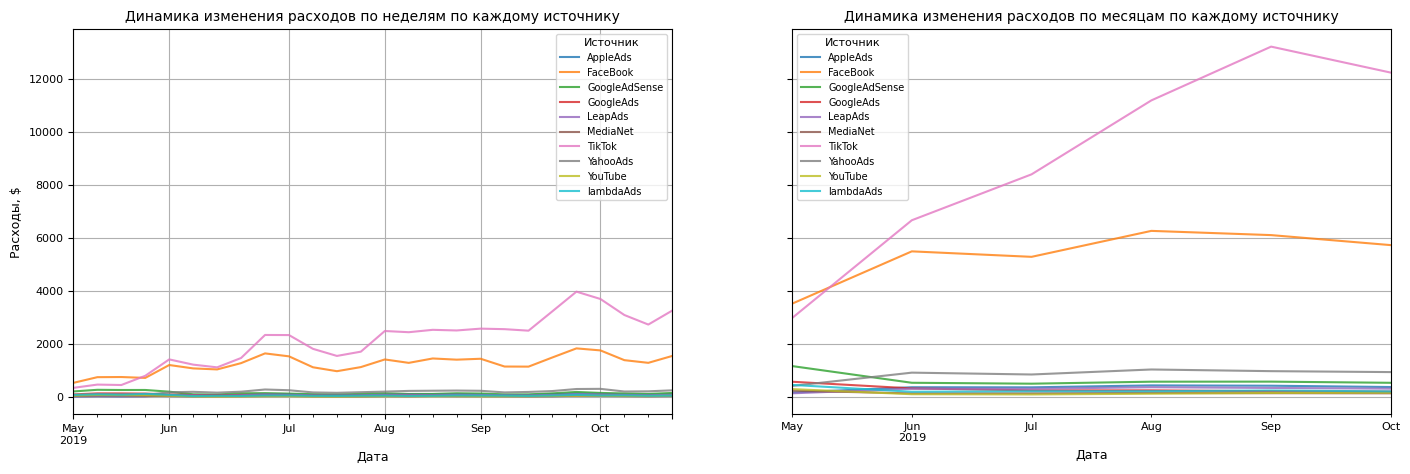

In [39]:
# задаём число строк и колонок, размер сетки для графиков, и задача осям Y быть одинаковыми внутри каждой строки подграфиков
fig, axes = plt.subplots(1, 2, figsize=(17, 5), sharey='row')

weekly_costs.plot(grid=True, ax=axes[0], alpha=0.8)
axes[0].set_title('Динамика изменения расходов по неделям по каждому источнику', fontsize=10)
axes[0].set_xlabel('Дата', fontsize=9)
axes[0].set_ylabel('Расходы, $', fontsize=9)
axes[0].tick_params(axis='both', which='both', labelsize=8)
axes[0].legend(title='Источник', title_fontsize=8, fontsize=7)

monthly_costs.plot(grid=True, ax=axes[1], alpha=0.8)
axes[1].set_title('Динамика изменения расходов по месяцам по каждому источнику', fontsize=10)
axes[1].set_xlabel('Дата', fontsize=9)
axes[1].set_ylabel('Расходы, $', fontsize=9)
axes[1].tick_params(axis='both', which='both', labelsize=8)
axes[1].legend(title='Источник', title_fontsize=8, fontsize=7)

plt.show()

Начиная с июня $2019$ года, расходы на рекламу по источнику `FaceBook` находятся примерно на одном уровне, около $6$ $000$ долларов в месяц, или около $1000-1500$ долларов в неделю.

Расходы по источнику `TikTok` с мая имеют восходящий тренд, каждый месяц траты на рекламу по этому источнику растут.\
Лишь в конце сентября траты по этому источнику убавились.

Может, имеет смысл попробовать вкладываться в рекламу по `lambdaAds` и `GoogleAdSense`? Процент платящих пользователей от них выше, чем от `TikTok`.

<br>

##### Узнаем среднюю стоимость привлечения одного пользователя (CAC) из каждого источника

In [40]:
channel_cac = profiles.groupby('channel')\
                      .agg({'acquisition_cost': 'mean'})\
                      .sort_values('acquisition_cost', ascending=False)
channel_cac['acquisition_cost'] = channel_cac['acquisition_cost'].round(2)
channel_cac['avg_acq_cost'] = (channel_cac['acquisition_cost'].mean()).round(2)
channel_cac

acquisition_cost  avg_acq_cost
channel                                      
TikTok                     2.80          0.69
FaceBook                   1.11          0.69
GoogleAdSense              1.01          0.69
lambdaAds                  0.72          0.69
YahooAds                   0.60          0.69
GoogleAds                  0.41          0.69
AppleAds                   0.25          0.69
YouTube                    0.22          0.69
MediaNet                   0.22          0.69
LeapAds                    0.21          0.69
organic                    0.00          0.69

В среднем самый дорогой пользователь — из канала `TikTok` $(2,8$ $\$)$, в то время как средний показатель <span style='font-weight: 600'>CAC</span> вне зависимости от источника — $0.69$ $\$$.\
Всего $4$ канала выше среднего показателя <span style='font-weight: 600'>CAC</span>.

<br>

<br>

## Когортный анализ

Когортный анализ покажет, как меняются: удержание, конверсия, пожизненная стоимость, стоимость привлечения, окупаемость пользователей в зависимости от устройства, страны, рекламного канала.

Будем считать, что на календаре дата, равная самой поздней дате первого посещения, то есть `2019-10-27`. <span style='font-weight: 600'>Это момент анализа.</span>\
А в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через $2$ недели после привлечения. <span style='font-weight: 600'>Это горизонт анализа.</span>

1. Отобразим графики <span style='font-weight: 600'>Retention Rate</span>, <span style='font-weight: 600'>Conversion Rate</span>, графики динамики <span style='font-weight: 600'>Retention Rate</span>, <span style='font-weight: 600'>Conversion Rate</span> в разрезе по:
   1. в общем;
   2. устройствам;
   3. странам;
   4. рекламным каналам.

Узнаем, окупаются ли привлечённые пользователи:

2. Отобразим графики <span style='font-weight: 600'>LTV</span> и <span style='font-weight: 600'>ROI</span>, графики динамики <span style='font-weight: 600'>LTV</span>, <span style='font-weight: 600'>CAC</span> и <span style='font-weight: 600'>ROI</span> в разрезе по:
    * в общем;
    * устройствам;
    * странам;
    * рекламным каналам.
3. Ответим на вопросы:
    * окупается ли реклама, направленная на привлечение пользователей в целом?
    * какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    * чем могут быть вызваны проблемы окупаемости?
4. Напишем выводы:
    * Выделим причины неэффективности привлечения пользователей.
    * Сформулируем рекомендации для отдела маркетинга.

При построении графиков динамики, будем использовать скользящее среднее, равное $7$ дням.\
Это нужно, чтобы сгладить графики, так как они могут быть шумными.

<br>

<span style='font-weight: 600'></span>

<span style='font-weight: 600'>Установим момент и горизонт анализа данных</span>

In [41]:
# момент анализа, равный самой поздней дате первого посещения
observation_date = profiles['dt'].max()

# горизонт анализа
horizon_days = 14 

<br>

<br>

### Удержание и конверсия

<br>

Сначала уберём `органических` пользователей из анализа, потому что на них ничего не затрачено, и поэтому они могут исказить статистику, когда мы будем считать юнит-экономику.\
В удержании и конверсии также будем смотреть без органики.

Получается, мы исключим $56$ $439$ человек, это $37.62\%$ от всего количества.	

In [42]:
without_organic_profiles = profiles[profiles['channel'] != 'organic']

<br>

#### По всем пользователям

Проанализируем удержание и конверсию по всем пользователям.

<br>

<span style='font-weight: 600'>Удержание</span>

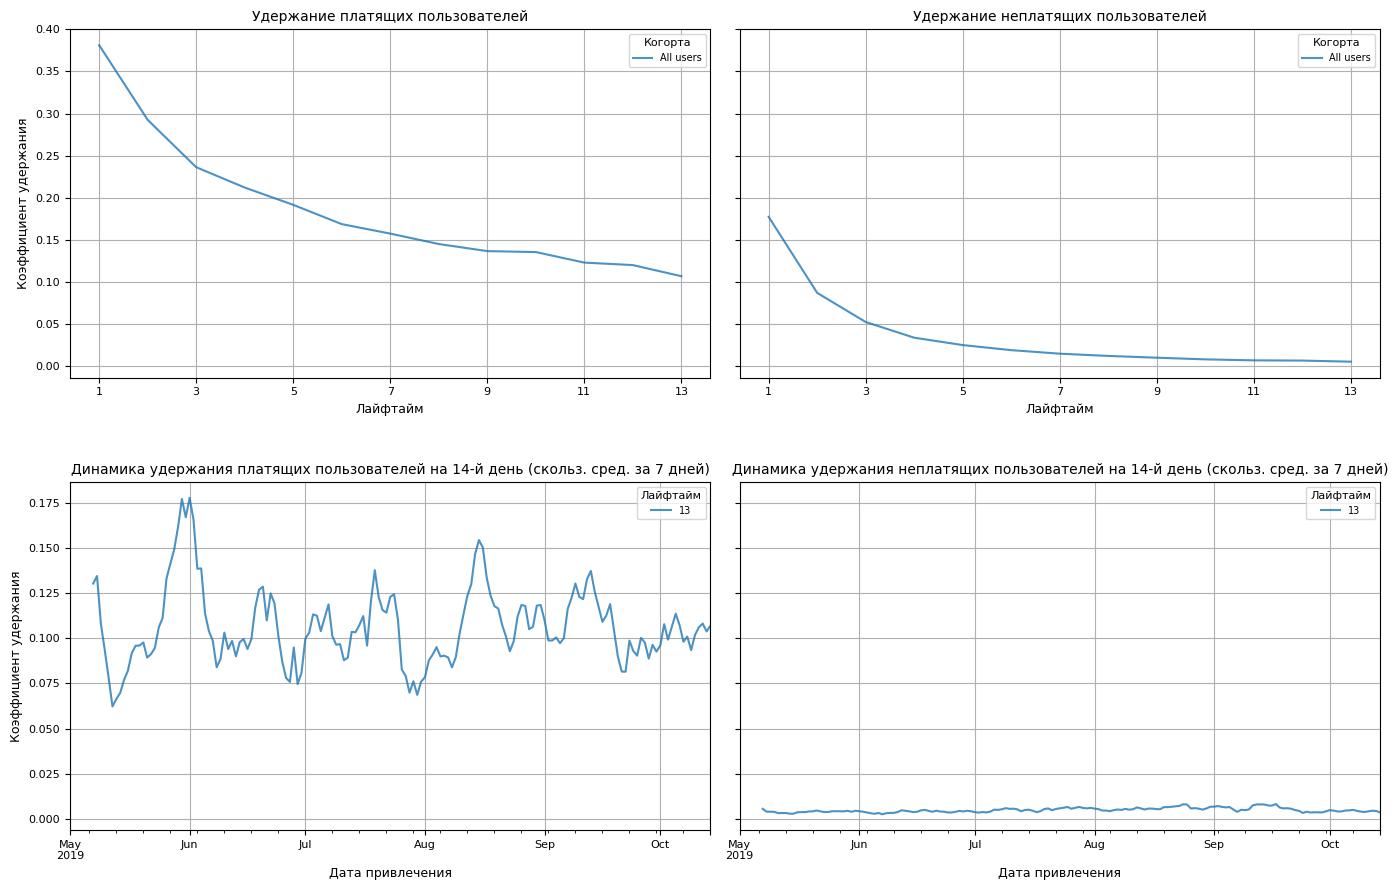

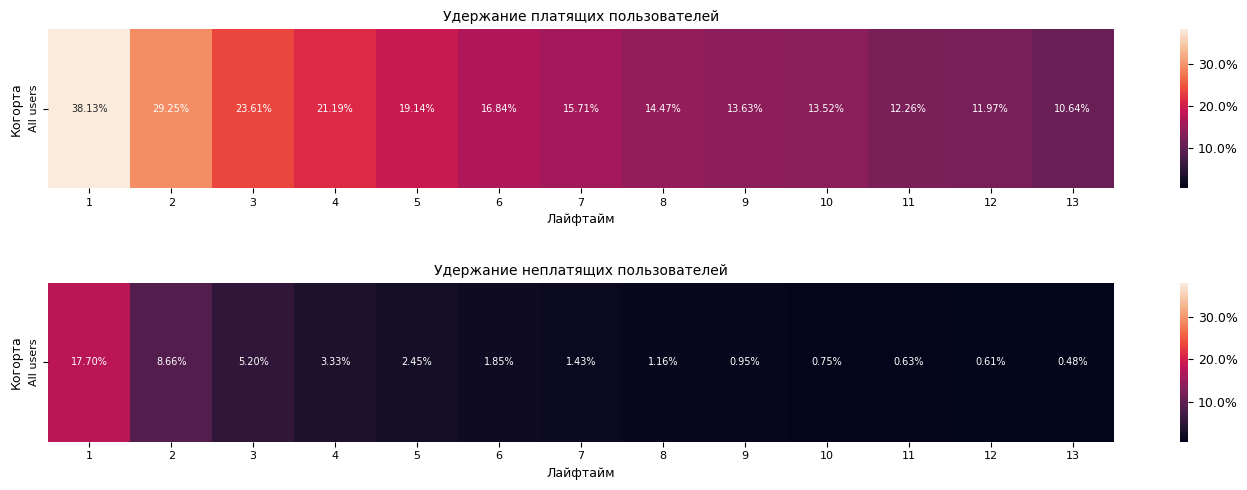

cohort_size    0         1         2         3         4         5  \
payer                                                                       
False        79036  1.0  0.177021  0.086593  0.051951  0.033289  0.024520   
True          7102  1.0  0.381301  0.292453  0.236131  0.211912  0.191355   

              6         7         8         9        10        11        12  \
payer                                                                         
False  0.018485  0.014272  0.011615  0.009489  0.007516  0.006339  0.006073   
True   0.168403  0.157139  0.144748  0.136300  0.135173  0.122642  0.119685   

             13  
payer            
False  0.004770  
True   0.106449

In [43]:
# удержание пользователей и динамика его изменения
retention_raw, retention, retention_history = get_retention(without_organic_profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False)

# визуализация удержания и его динамики
plot_retention(retention, retention_history, horizon_days, 'Когорта', 'Лайфтайм', 7, 'дней') 

print('\n')
heatmap_retention(retention, 'Когорта')
print('\n')
display(retention)

In [44]:
print('Минимальные значения удержания 14-го дня для неплатящих и платящих')
print('')
print((retention_history[[13]].reset_index().pivot_table(index='dt', columns='payer', values=13, aggfunc='mean').rolling(7).mean().min() * 100).round(2))
print('\n')
print('Максимальные значения удержания 14-го дня для неплатящих и платящих')
print('')
print((retention_history[[13]].reset_index().pivot_table(index='dt', columns='payer', values=13, aggfunc='mean').rolling(7).mean().max() * 100).round(2))

Минимальные значения удержания 14-го дня для неплатящих и платящих

payer
False    0.24
True     6.22
dtype: float64


Максимальные значения удержания 14-го дня для неплатящих и платящих

payer
False     0.81
True     17.80
dtype: float64


Кривые удержания и хитмэп показывают, что:
1. $10.64\%$ из тех, кто заплатил, вернулись к $14$-му дню.
2. Неплатящие пользователи почти полностью теряют интерес к продукту уже после первой недели, отображая среднее удержание $14$-го дня на отметке в $0.48\%$.

Удержание $14$-го дня в течение всего времени:
1. Для платящих варьируется в пределах от $6.22\%$ до $17.8\%$.
2. Для неплатящих варьируется в пределах от $0.24\%$ до $0.81\%$.

<br>

<br>

<span style='font-weight: 600'>Конверсия

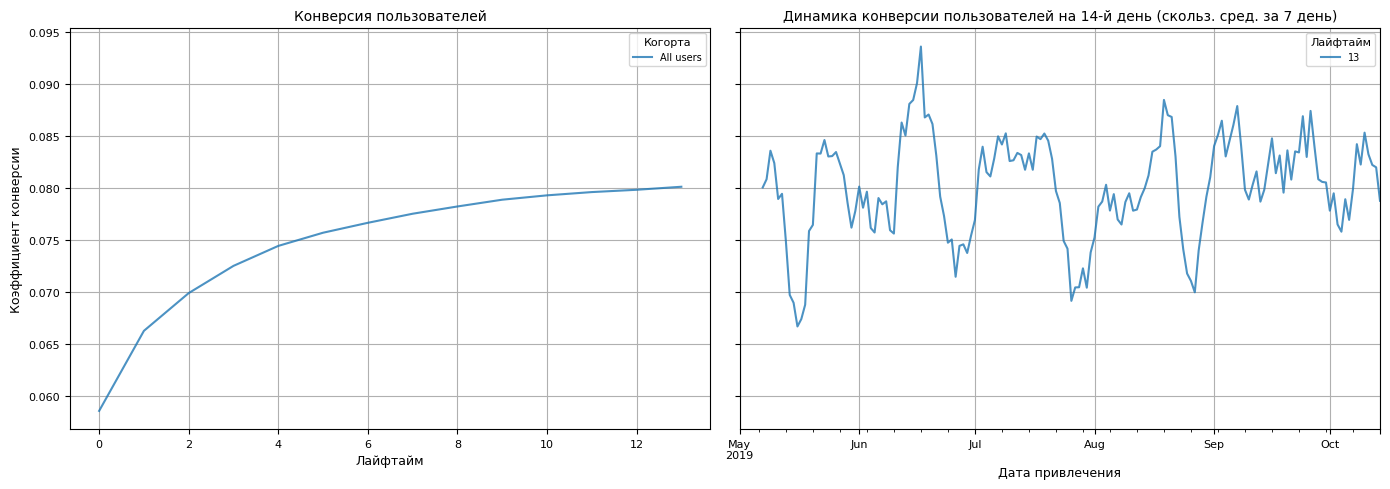



Таблица конверсии


cohort_size         0         1         2         3         4  \
cohort                                                                     
All users        86138  0.058604  0.066289  0.069911  0.072523  0.074439   

                  5         6         7         8         9        10  \
cohort                                                                  
All users  0.075704  0.076656  0.077527  0.078223  0.078873  0.079291   

                 11        12        13  
cohort                                   
All users  0.079605  0.079825  0.080116

In [45]:
# конверсия пользователей и динамика её изменения
conversion_raw, conversion, conversion_history = get_conversion(without_organic_profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False)

# визуализация конверсии и динамики её изменения
plot_conversion(conversion, conversion_history, horizon_days, 'Когорта', 'Лайфтайм', 7, 'день')

print('\n')
print('Таблица конверсии')
display(conversion)

In [46]:
print('Минимальное значение конверсии 14-го дня')
print((conversion_history[[13]].rolling(7).mean().min() * 100).round(2))
print('')
print('Максимальное значение конверсии 14-го дня')
print((conversion_history[[13]].rolling(7).mean().max() * 100).round(2))

Минимальное значение конверсии 14-го дня
13    6.67
dtype: float64

Максимальное значение конверсии 14-го дня
13    9.36
dtype: float64


Конверсия к концу второй недели равна $8.0\%$.\
В течение всего рассматриваемого времени конверсия $14$-го дня скачет от $6.6\%$ до $9.3\%$.

<br>

<br>

#### По устройствам

Проанализируем удержание и конверсию по отдельным устройствам.

<br>

<span style='font-weight: 600'>Удержание</span>

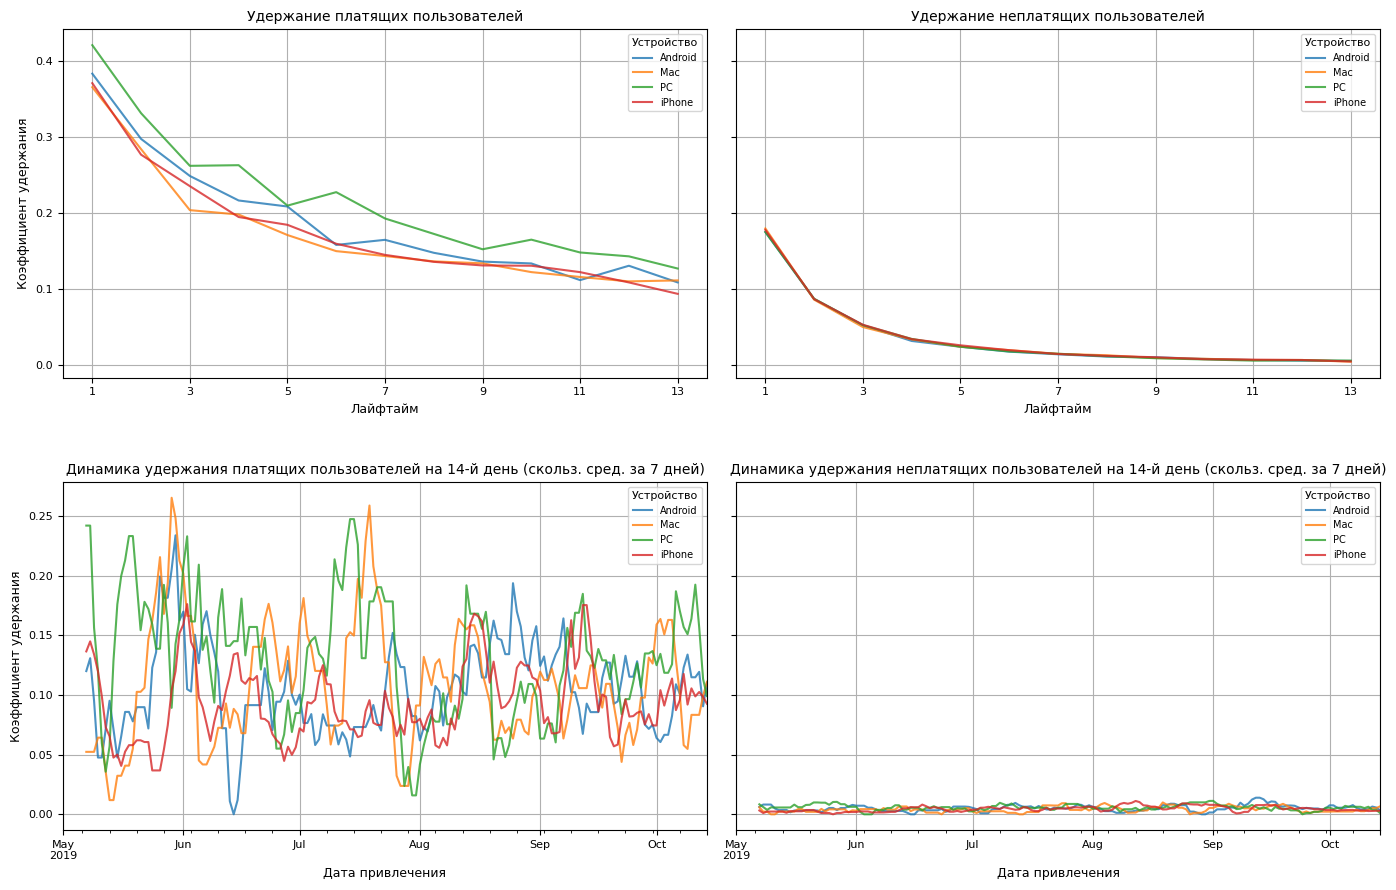

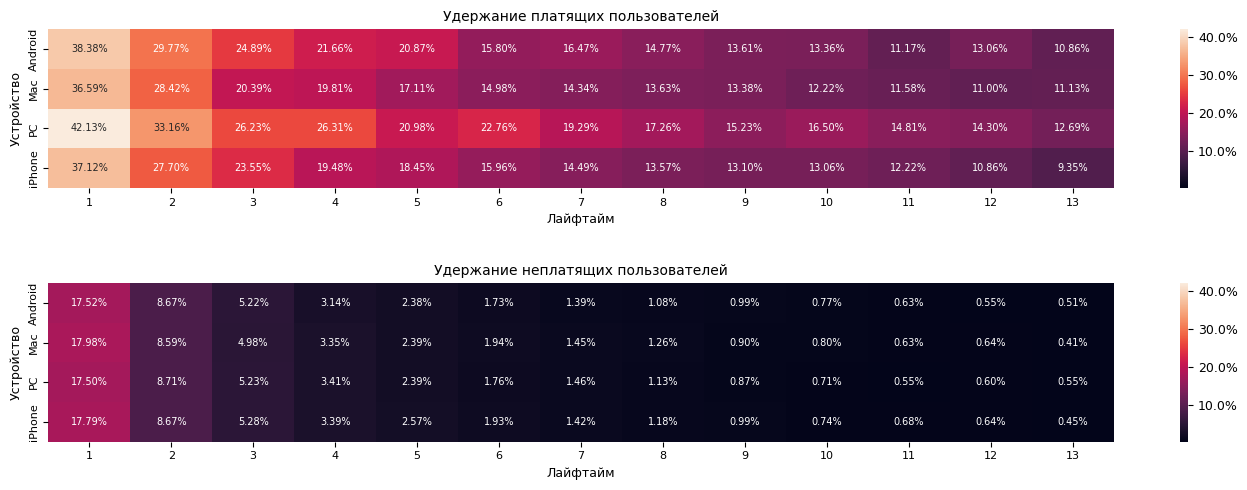



Таблица удержания


cohort_size    0         1         2         3         4  \
payer device                                                              
False Android        18453  1.0  0.175202  0.086653  0.052187  0.031431   
      Mac            15708  1.0  0.179781  0.085880  0.049784  0.033486   
      PC             16430  1.0  0.174985  0.087097  0.052282  0.034145   
      iPhone         28445  1.0  0.177852  0.086658  0.052804  0.033890   
True  Android         1639  1.0  0.383771  0.297743  0.248932  0.216595   
      Mac             1555  1.0  0.365916  0.284244  0.203859  0.198071   
      PC              1182  1.0  0.421320  0.331641  0.262267  0.263113   
      iPhone          2726  1.0  0.371240  0.276963  0.235510  0.194791   

                      5         6         7         8         9        10  \
payer device                                                                
False Android  0.023790  0.017341  0.013873  0.010838  0.009917  0.007749   
      Mac      0.023873  0.019353  0.014451  0.012605  0.008976  0.007958   
      PC       0.023920  0.017590  0.014607  0.011260  0.008704  0.007060   
      iPhone   0.025699  0.019265  0.014238  0.011777  0.009949  0.007383   
True  Android  0.208664  0.158023  0.164735  0.147651  0.136059  0.133618   
      Mac      0.171061  0.149839  0.143408  0.136334  0.133762  0.122186   
      PC       0.209814  0.227580  0.192893  0.172589  0.152284  0.164975   
      iPhone   0.184519  0.159574  0.144901  0.135730  0.130961  0.130594   

                     11        12        13  
payer device                                 
False Android  0.006340  0.005473  0.005094  
      Mac      0.006303  0.006366  0.004138  
      PC       0.005539  0.005965  0.005539  
      iPhone   0.006820  0.006363  0.004465  
True  Android  0.111653  0.130567  0.108603  
      Mac      0.115756  0.109968  0.111254  
      PC       0.148054  0.142978  0.126904  
      iPhone   0.122157  0.108584  0.093544

In [47]:
# удержание пользователей и динамика его изменения
retention_raw, retention, retention_history = get_retention(without_organic_profiles, visits, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False)

# визуализация удержания и его динамики
plot_retention(retention, retention_history, horizon_days, 'Устройство', 'Устройство', 7, 'дней') 

print('\n')
heatmap_retention(retention, 'Устройство')
print('\n')
print('Таблица удержания')
display(retention)

У платящих больше всего получается удерживать владельцев `ПК`.\
Их уровень удержания на $14$-й день находится на отметке $12.69\%$.

У неплатящих ожидаемо всё очень плохо.\
Среднее удержание $14$-го дня не превышает $0.55\%$ по любому из устройств.

<br>

<br>

<span style='font-weight: 600'>Конверсия</span>

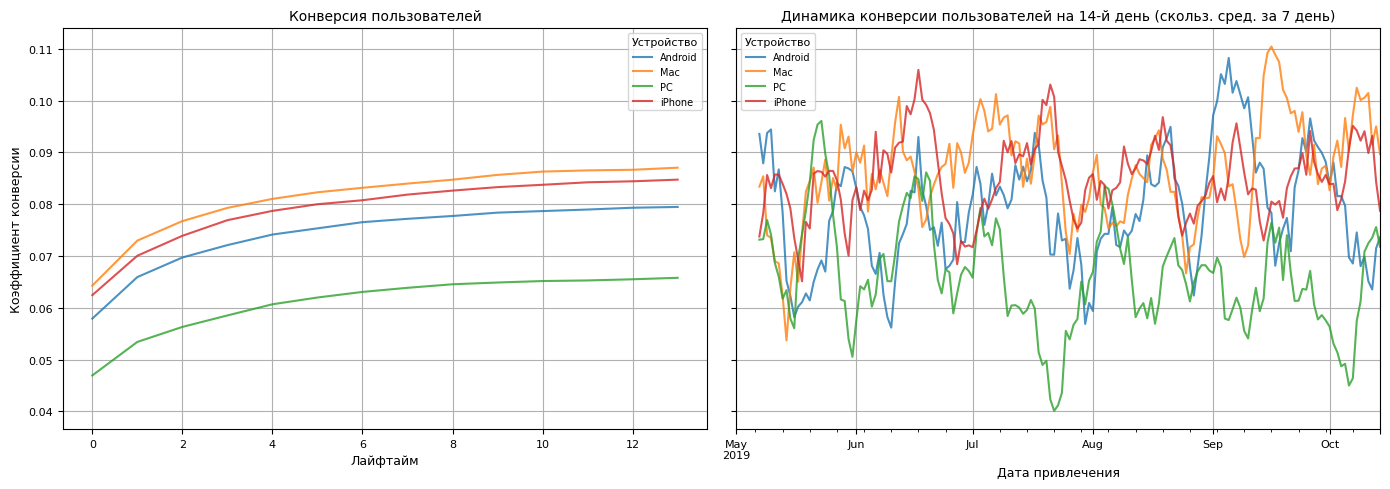



Таблица конверсии


cohort_size         0         1         2         3         4  \
device                                                                   
Android        20092  0.057934  0.065947  0.069729  0.072118  0.074159   
Mac            17263  0.064299  0.072988  0.076754  0.079303  0.081040   
PC             17612  0.046957  0.053429  0.056325  0.058540  0.060697   
iPhone         31171  0.062462  0.070065  0.073915  0.076930  0.078727   

                5         6         7         8         9        10        11  \
device                                                                          
Android  0.075353  0.076548  0.077195  0.077742  0.078389  0.078688  0.078987   
Mac      0.082315  0.083184  0.083995  0.084748  0.085675  0.086312  0.086543   
PC       0.062003  0.063082  0.063877  0.064558  0.064899  0.065183  0.065296   
iPhone   0.080010  0.080780  0.081871  0.082641  0.083315  0.083764  0.084245   

               12        13  
device                       
Android  0.079335  0.079484  
Mac      0.086659  0.087065  
PC       0.065524  0.065807  
iPhone   0.084437  0.084758

In [48]:
# конверсия пользователей и динамика её изменения
conversion_raw, conversion, conversion_history = get_conversion(without_organic_profiles, orders, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False)

# визуализация конверсии и динамики её изменения
plot_conversion(conversion, conversion_history, horizon_days, 'Устройство', 'Устройство', 7, 'день')

print('\n')
print('Таблица конверсии')
display(conversion)

Самая высокая средняя конверсия на $14$-й день — у владельцев `Mac` и `iPhone` — $8.7\%$ и $8.4\%$\
`PC` пользователи конвертируются в покупатели хуже всех — $6.5\%$.

<br>

<br>

#### По странам

Проанализируем удержание и конверсию по отдельным странам.

<br>

<span style='font-weight: 600'>Удержание</span>

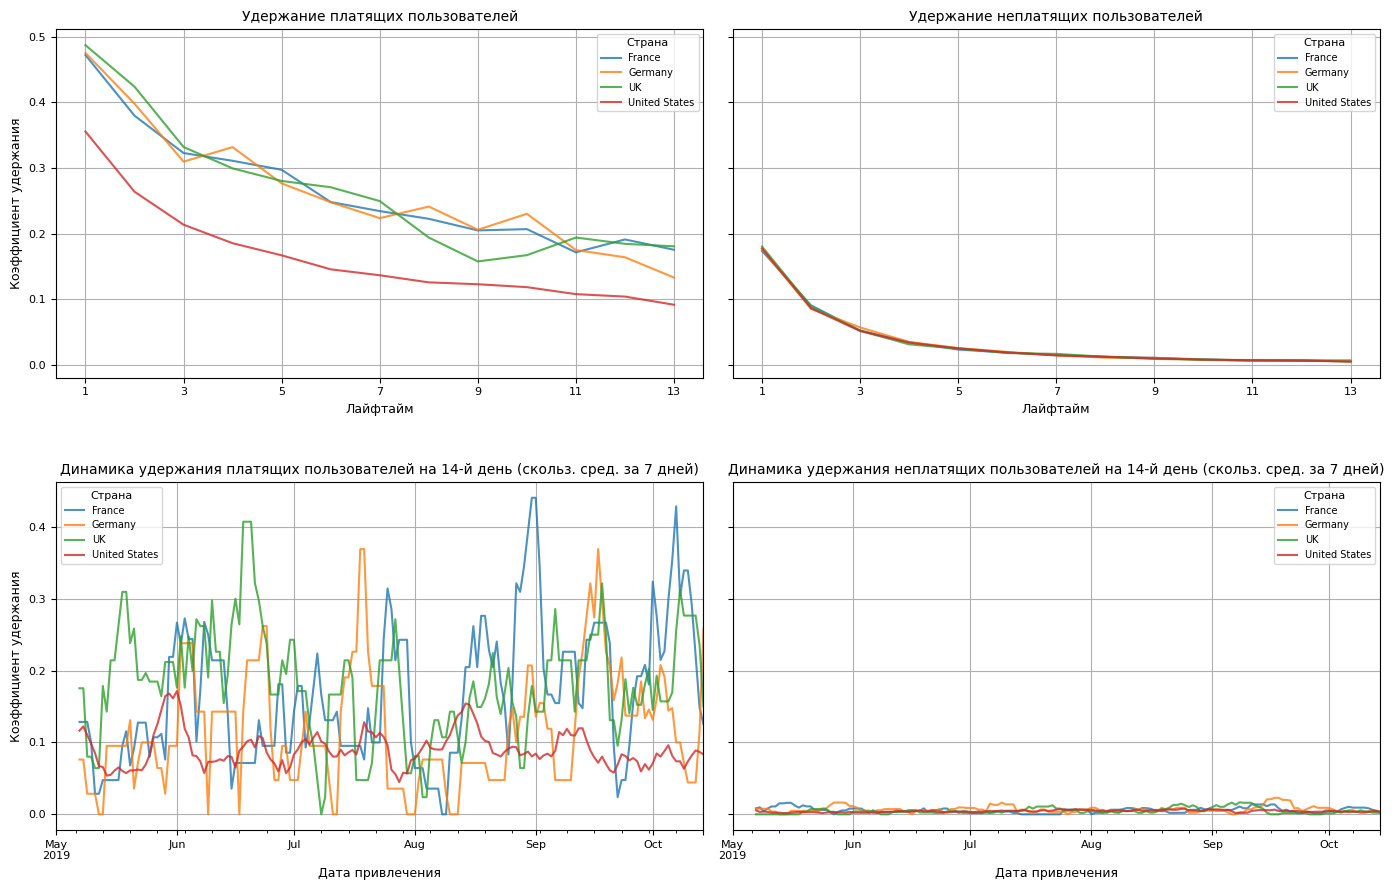

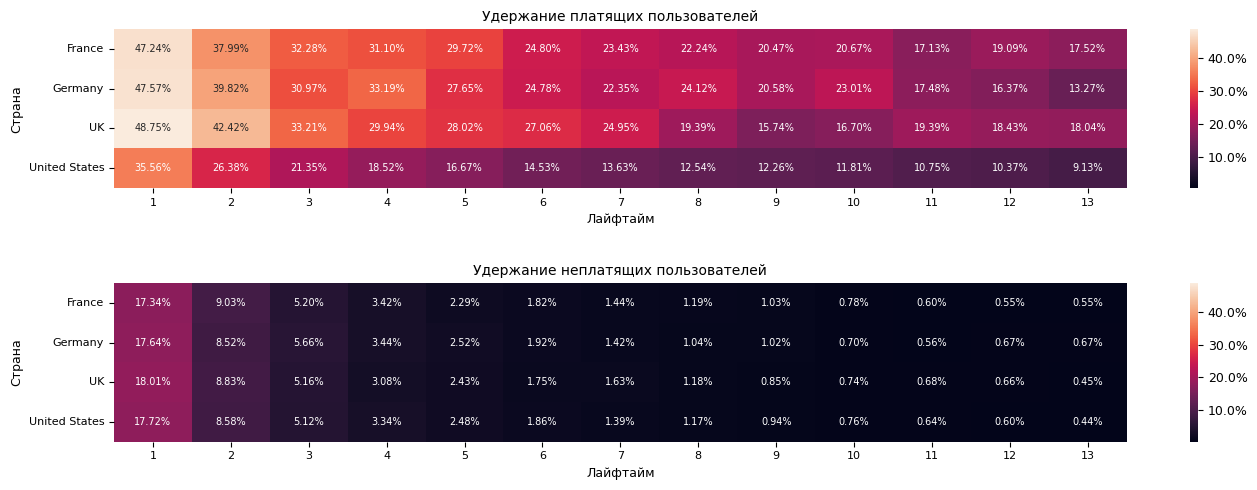



Таблица удержания


cohort_size    0         1         2         3         4  \
payer region                                                                    
False France                9709  1.0  0.173447  0.090329  0.052014  0.034195   
      Germany               8335  1.0  0.176365  0.085183  0.056629  0.034433   
      UK                    9711  1.0  0.180105  0.088250  0.051591  0.030790   
      United States        51281  1.0  0.177220  0.085802  0.051247  0.033404   
True  France                 508  1.0  0.472441  0.379921  0.322835  0.311024   
      Germany                452  1.0  0.475664  0.398230  0.309735  0.331858   
      UK                     521  1.0  0.487524  0.424184  0.332054  0.299424   
      United States         5621  1.0  0.355631  0.263832  0.213485  0.185198   

                            5         6         7         8         9  \
payer region                                                            
False France         0.022865  0.018231  0.014420  0.011948  0.010300   
      Germany        0.025195  0.019196  0.014157  0.010438  0.010198   
      UK             0.024302  0.017506  0.016270  0.011842  0.008547   
      United States  0.024766  0.018603  0.013884  0.011700  0.009399   
True  France         0.297244  0.248031  0.234252  0.222441  0.204724   
      Germany        0.276549  0.247788  0.223451  0.241150  0.205752   
      UK             0.280230  0.270633  0.249520  0.193858  0.157390   
      United States  0.166696  0.145348  0.136275  0.125423  0.122576   

                           10        11        12        13  
payer region                                                 
False France         0.007828  0.005974  0.005459  0.005459  
      Germany        0.006959  0.005639  0.006719  0.006719  
      UK             0.007414  0.006796  0.006590  0.004531  
      United States  0.007566  0.006435  0.005987  0.004368  
True  France         0.206693  0.171260  0.190945  0.175197  
      Germany        0.230088  0.174779  0.163717  0.132743  
      UK             0.166987  0.193858  0.184261  0.180422  
      United States  0.118128  0.107454  0.103718  0.091265

In [49]:
# удержание пользователей и динамика его изменения
retention_raw, retention, retention_history = get_retention(without_organic_profiles, visits, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False)

# визуализация удержания и его динамики
plot_retention(retention, retention_history, horizon_days, 'Страна', 'Страна', 7, 'дней') 

print('\n')
heatmap_retention(retention, 'Страна')
print('\n')
print('Таблица удержания')
display(retention)

Удержание платящих пользователей `США` находится ниже пользователей других стран — на уровне $9.1\%$.\
Лидерами являются `Великобритания` и `Франция` — $18\%$ и $17.5\%$.

<br>

<br>

<span style='font-weight: 600'>Конверсия</span>

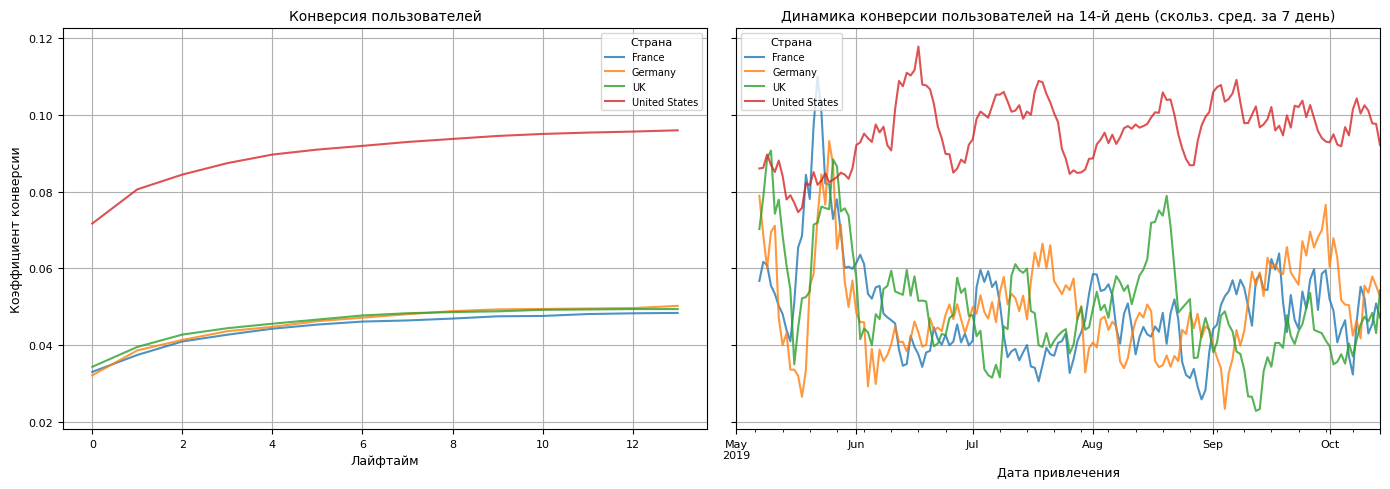



Таблица конверсии


cohort_size         0         1         2         3         4  \
region                                                                         
France               10217  0.032984  0.037389  0.040912  0.042674  0.044240   
Germany               8787  0.032093  0.038580  0.041311  0.043587  0.044725   
UK                   10232  0.034304  0.039484  0.042709  0.044371  0.045543   
United States        56902  0.071667  0.080577  0.084426  0.087413  0.089645   

                      5         6         7         8         9        10  \
region                                                                      
France         0.045317  0.046100  0.046393  0.046883  0.047470  0.047568   
Germany        0.046205  0.047115  0.048025  0.048822  0.049277  0.049391   
UK             0.046618  0.047694  0.048280  0.048573  0.048769  0.049159   
United States  0.090946  0.091912  0.092932  0.093723  0.094496  0.095023   

                     11        12        13  
region                                       
France         0.048057  0.048253  0.048351  
Germany        0.049505  0.049619  0.050188  
UK             0.049257  0.049355  0.049355  
United States  0.095375  0.095638  0.095972

In [50]:
# конверсия пользователей и динамика её изменения
conversion_raw, conversion, conversion_history = get_conversion(without_organic_profiles, orders, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False)

# визуализация конверсии и его динамики
plot_conversion(conversion, conversion_history, horizon_days, 'Страна', 'Страна', 7, 'день')

print('\n')
print('Таблица конверсии')
display(conversion)

Несмотря на то, что у платящих пользователей `США` проблемы с удержанием, конвертируется они лучше всех — в среднем $9.5\%$ пользователей становятся покупателями к $14$-му дню.\
В то время как у пользователей из других стран конверсия к этому дню не превышает $5\%$.

<br>

<br>

#### По рекламным каналам

Проанализируем удержание и конверсию по отдельным каналам привлечения.\
Здесь можно без вреда включить `органику`.

<br>

<span style='font-weight: 600'>Удержание</span>

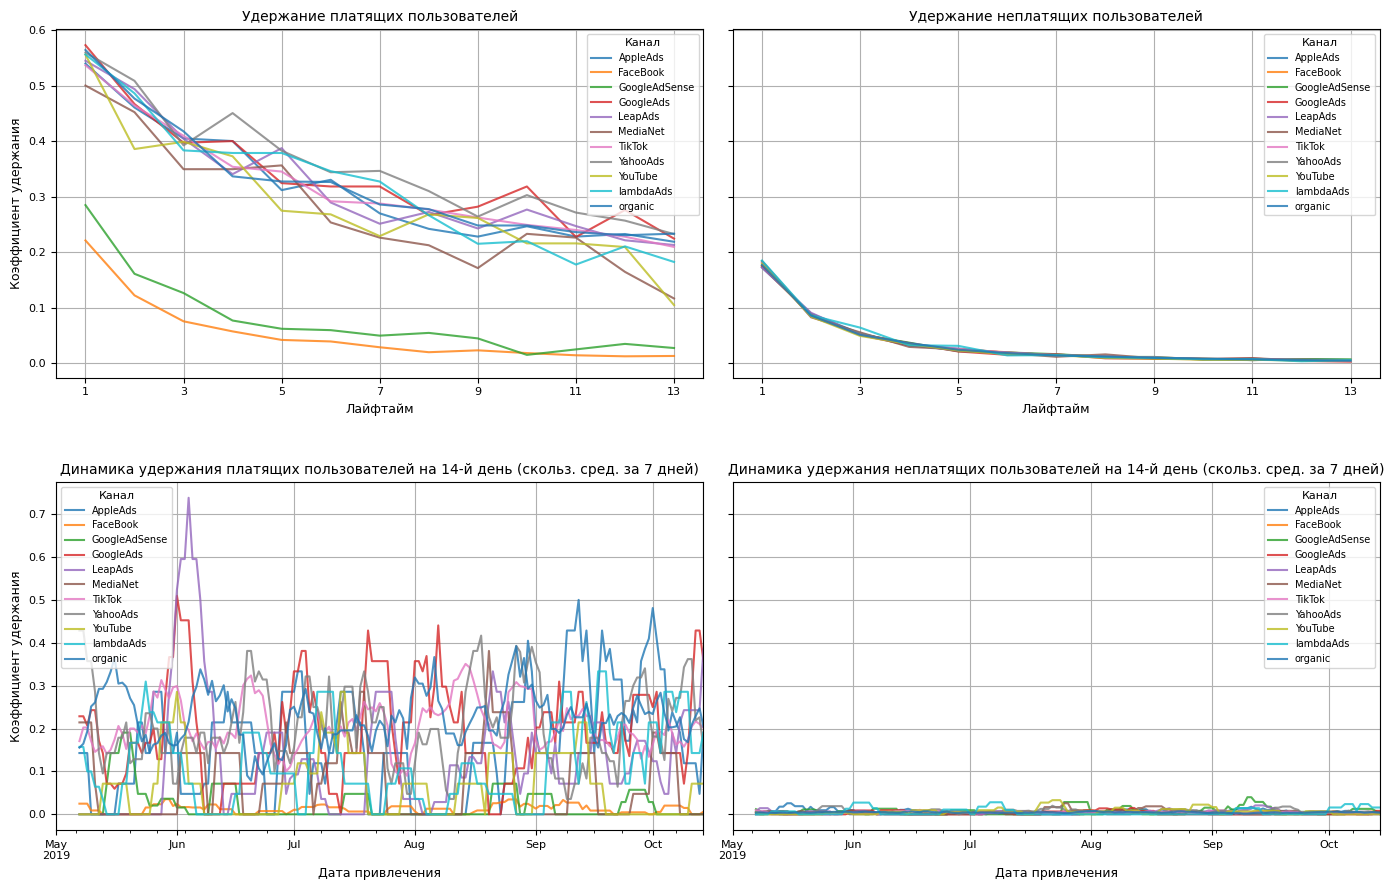

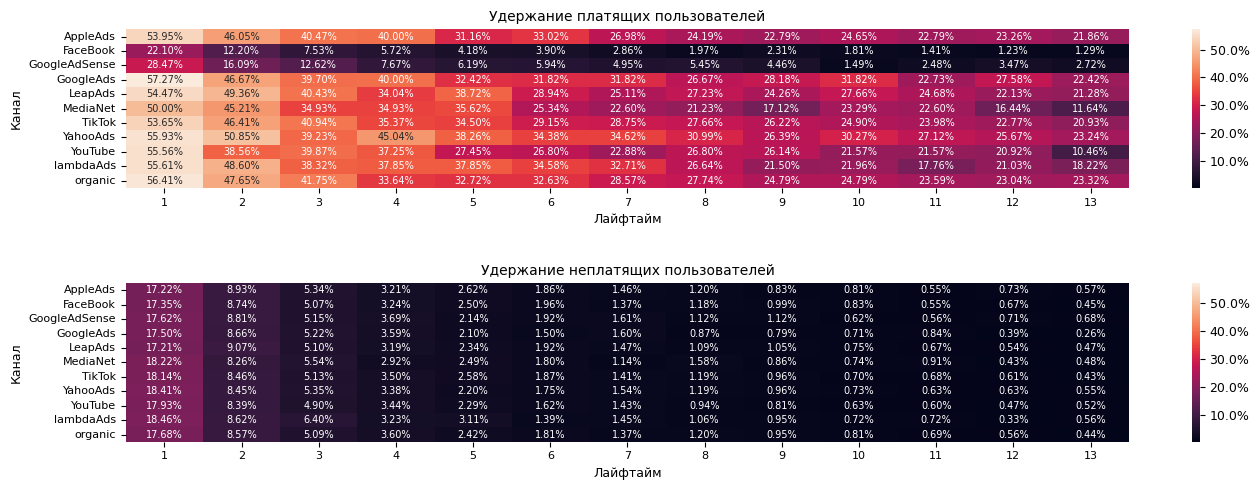



Таблица удержания


cohort_size    0         1         2         3         4  \
payer channel                                                                   
True  organic               1085  1.0  0.564055  0.476498  0.417512  0.336406   
      YahooAds               413  1.0  0.559322  0.508475  0.392252  0.450363   
      GoogleAds              330  1.0  0.572727  0.466667  0.396970  0.400000   
      AppleAds               215  1.0  0.539535  0.460465  0.404651  0.400000   
      LeapAds                235  1.0  0.544681  0.493617  0.404255  0.340426   
      TikTok                1739  1.0  0.536515  0.464060  0.409431  0.353652   
      lambdaAds              214  1.0  0.556075  0.485981  0.383178  0.378505   
      MediaNet               146  1.0  0.500000  0.452055  0.349315  0.349315   
      YouTube                153  1.0  0.555556  0.385621  0.398693  0.372549   
      GoogleAdSense          404  1.0  0.284653  0.160891  0.126238  0.076733   
      FaceBook              3253  1.0  0.221027  0.122041  0.075315  0.057178   
False GoogleAdSense         3223  1.0  0.176233  0.088117  0.051505  0.036922   
      AppleAds              7675  1.0  0.172248  0.089251  0.053420  0.032052   
      lambdaAds             1798  1.0  0.184650  0.086207  0.063960  0.032258   
      YahooAds              7419  1.0  0.184122  0.084513  0.053511  0.033832   
      YouTube               3837  1.0  0.179307  0.083920  0.048997  0.034402   
      MediaNet              3935  1.0  0.182211  0.082592  0.055400  0.029225   
      LeapAds               7640  1.0  0.172120  0.090707  0.051047  0.031937   
      FaceBook             23483  1.0  0.173530  0.087382  0.050718  0.032406   
      organic              51542  1.0  0.176846  0.085678  0.050949  0.036009   
      TikTok               16214  1.0  0.181386  0.084557  0.051314  0.035031   
      GoogleAds             3812  1.0  0.174974  0.086569  0.052204  0.035939   

                            5         6         7         8         9  \
payer channel                                                           
True  organic        0.327189  0.326267  0.285714  0.277419  0.247926   
      YahooAds       0.382567  0.343826  0.346247  0.309927  0.263923   
      GoogleAds      0.324242  0.318182  0.318182  0.266667  0.281818   
      AppleAds       0.311628  0.330233  0.269767  0.241860  0.227907   
      LeapAds        0.387234  0.289362  0.251064  0.272340  0.242553   
      TikTok         0.345026  0.291547  0.287522  0.276596  0.262220   
      lambdaAds      0.378505  0.345794  0.327103  0.266355  0.214953   
      MediaNet       0.356164  0.253425  0.226027  0.212329  0.171233   
      YouTube        0.274510  0.267974  0.228758  0.267974  0.261438   
      GoogleAdSense  0.061881  0.059406  0.049505  0.054455  0.044554   
      FaceBook       0.041808  0.039041  0.028589  0.019674  0.023056   
False GoogleAdSense  0.021409  0.019237  0.016134  0.011170  0.011170   
      AppleAds       0.026189  0.018632  0.014593  0.011987  0.008339   
      lambdaAds      0.031146  0.013904  0.014461  0.010567  0.009455   
      YahooAds       0.021971  0.017523  0.015366  0.011861  0.009570   
      YouTube        0.022935  0.016158  0.014334  0.009382  0.008079   
      MediaNet       0.024905  0.018043  0.011436  0.015756  0.008640   
      LeapAds        0.023429  0.019241  0.014660  0.010864  0.010471   
      FaceBook       0.024954  0.019589  0.013712  0.011753  0.009879   
      organic        0.024155  0.018141  0.013736  0.011971  0.009487   
      TikTok         0.025780  0.018749  0.014124  0.011903  0.009560   
      GoogleAds      0.020986  0.014953  0.016002  0.008657  0.007870   

                           10        11        12        13  
payer channel                                                
True  organic        0.247926  0.235945  0.230415  0.233180  
      YahooAds       0.302663  0.271186  0.256659  0.232446  
      GoogleAds      0.318182  0.227273  0.275758  0.224242  
      AppleAd

In [51]:
# удержание пользователей и динамика его изменения
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False)

# визуализация удержания и его динамики
plot_retention(retention, retention_history, horizon_days, 'Канал', 'Канал', 7, 'дней') 

print('\n')
heatmap_retention(retention, 'Канал')
print('\n')
print('Таблица удержания')
display(retention.sort_values(by=13, ascending=False))

Смотрим платящих пользователей, так как у неплатящих всё стабильно плохо и неинтересно.

Лучший показатель удержания у `органических` пользователей — $23.3\%$ — на них компания не потратила денег.\
В этом есть рациональное зерно, такие пользователи пришли сами, их никто не звал.

Но `органическим` пользователям наступают на пятки пользователи из других источников: `YahooAds`, `GoogleAds`, `AppleAds`, `LeapAds`.\
Все они остают не более чем на $2\%$ от `органических`.
 
Яркими же аутсайдерами являются пользователи из источников `GoogleAdSense` и `FaceBook`.\
Их удержание находится на уровне $2.7\%$ и $1.2\%$.

<br>

<br>

<span style='font-weight: 600'>Конверсия</span>

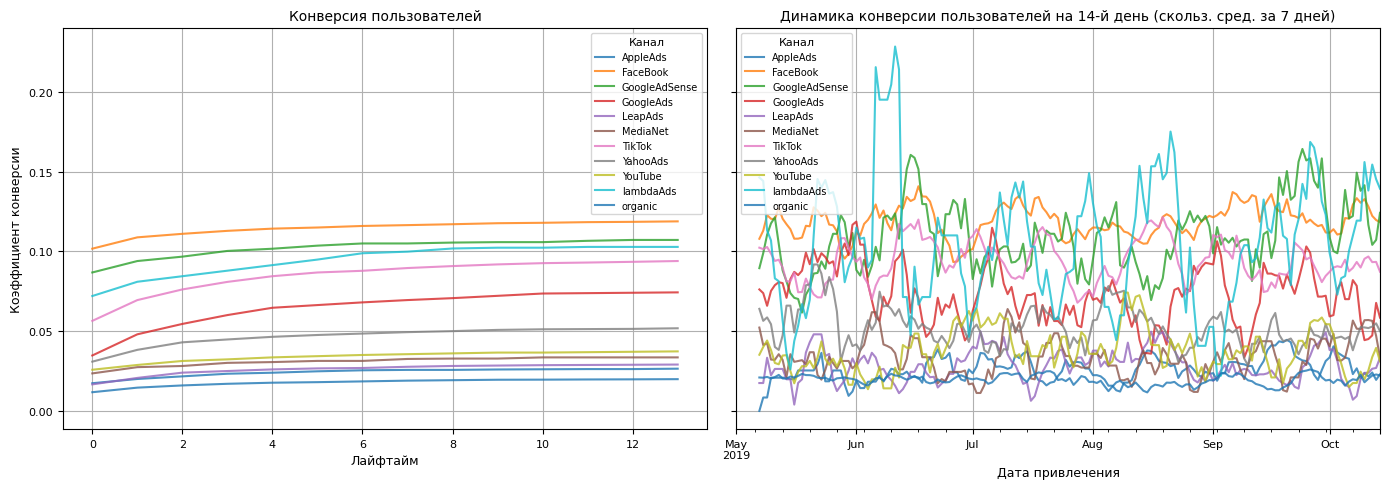



Таблица конверсии


cohort_size         0         1         2         3         4  \
channel                                                                        
FaceBook             26736  0.101773  0.108879  0.111086  0.112956  0.114340   
GoogleAdSense         3627  0.086849  0.094017  0.096774  0.100358  0.101737   
lambdaAds             2012  0.072068  0.081014  0.084493  0.087972  0.091451   
TikTok               17953  0.056481  0.069515  0.076199  0.080934  0.084498   
GoogleAds             4142  0.034766  0.048044  0.054563  0.060116  0.064703   
YahooAds              7832  0.030899  0.038304  0.043029  0.044816  0.046476   
YouTube               3990  0.025815  0.028822  0.031328  0.032331  0.033584   
MediaNet              4081  0.023524  0.027444  0.028179  0.030140  0.030630   
LeapAds               7875  0.016635  0.020698  0.024000  0.025016  0.026032   
AppleAds              7890  0.017364  0.020025  0.021673  0.023321  0.023954   
organic              52627  0.011724  0.014593  0.015980  0.017006  0.017691   

                      5         6         7         8         9        10  \
channel                                                                     
FaceBook       0.115051  0.116023  0.116547  0.117108  0.117744  0.118006   
GoogleAdSense  0.103667  0.105045  0.105045  0.105597  0.105873  0.105873   
lambdaAds      0.094930  0.098907  0.099901  0.101889  0.102386  0.102386   
TikTok         0.086838  0.087896  0.089623  0.090848  0.091907  0.092686   
GoogleAds      0.066393  0.068083  0.069532  0.070739  0.072187  0.073636   
YahooAds       0.047625  0.048519  0.049413  0.050051  0.050817  0.051200   
YouTube        0.034336  0.035088  0.035589  0.036090  0.036591  0.036591   
MediaNet       0.031365  0.031365  0.032590  0.032835  0.032835  0.033570   
LeapAds        0.026667  0.026921  0.027683  0.028190  0.028444  0.028698   
AppleAds       0.024842  0.025475  0.025729  0.025729  0.025982  0.026109   
organic        0.018033  0.018508  0.018983  0.019268  0.019553  0.019610   

                     11        12        13  
channel                                      
FaceBook       0.118417  0.118604  0.118903  
GoogleAdSense  0.106700  0.107251  0.107251  
lambdaAds      0.102883  0.102883  0.102883  
TikTok         0.093076  0.093522  0.094023  
GoogleAds      0.073877  0.074119  0.074360  
YahooAds       0.051328  0.051456  0.051839  
YouTube        0.036842  0.037093  0.037343  
MediaNet       0.033570  0.033570  0.033570  
LeapAds        0.028825  0.028952  0.029079  
AppleAds       0.026236  0.026236  0.026489  
organic        0.019724  0.019800  0.019914

In [52]:
# конверсия пользователей и динамика её изменения
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False)

# визуализация конверсии и её динамики
plot_conversion(conversion, conversion_history, horizon_days, 'Канал', 'Канал', 7, 'дней')

print('\n')
print('Таблица конверсии')
display(conversion.sort_values(by=13, ascending=False))

Лучше всех конвертируются пользователи, которые пришли из каналов:
* `FaceBook` — $11.8\%$
* `GoogleAdSense` — $10.7\%$
* `lambdaAds` — $10.2\%$

Хуже всех:
* `organic` — $1.9\%$
* `AppleAds` — $2.6\%$
* `LeapAds` — $2.9\%$

Картина такая, что `органические` пользователи лучше всех удерживаются, но хуже всех конвертируются.\
А пользователи из `FaceBook` и `GoogleAdSense` наоборот — лучше всех конвертируются, но хуже всех удерживаются.

<br>

<br>

### Юнит-экономика

На этом этапе будем смотреть <span style='font-weight: 600'>юнит-экономику</span>, которая даст ответ на вопрос, приносят ли наши пользователи (юниты) прибыль или нет.\
Чтобы понять это, нужно выяснить:
* <span style='font-weight: 600'>LTV (LifeTime Value)</span> — сколько в среднем накопительной выручки приносит один клиент в определённый лайфтайм.
* <span style='font-weight: 600'>CAC (Customer Acquisition Cost)</span> — сколько в среднем затрачено денег на одного клиента за определённый день.
* <span style='font-weight: 600'>ROI (Return On Investment)</span> — это <span style='font-weight: 600'>LTV</span> делённый на <span style='font-weight: 600'>CAC</span>. Как раз таки <span style='font-weight: 600'>ROI</span> и даст ответ, есть ли окупаемость? 

<br>

<br>

#### По всем пользователям

Сначала рассчитаем <span style='font-weight: 600'>юнит-экономику</span> по всем пользователям.

In [53]:
without_bad_channels = without_organic_profiles[~without_organic_profiles['channel'].isin(['FaceBook', 'TikTok'])]

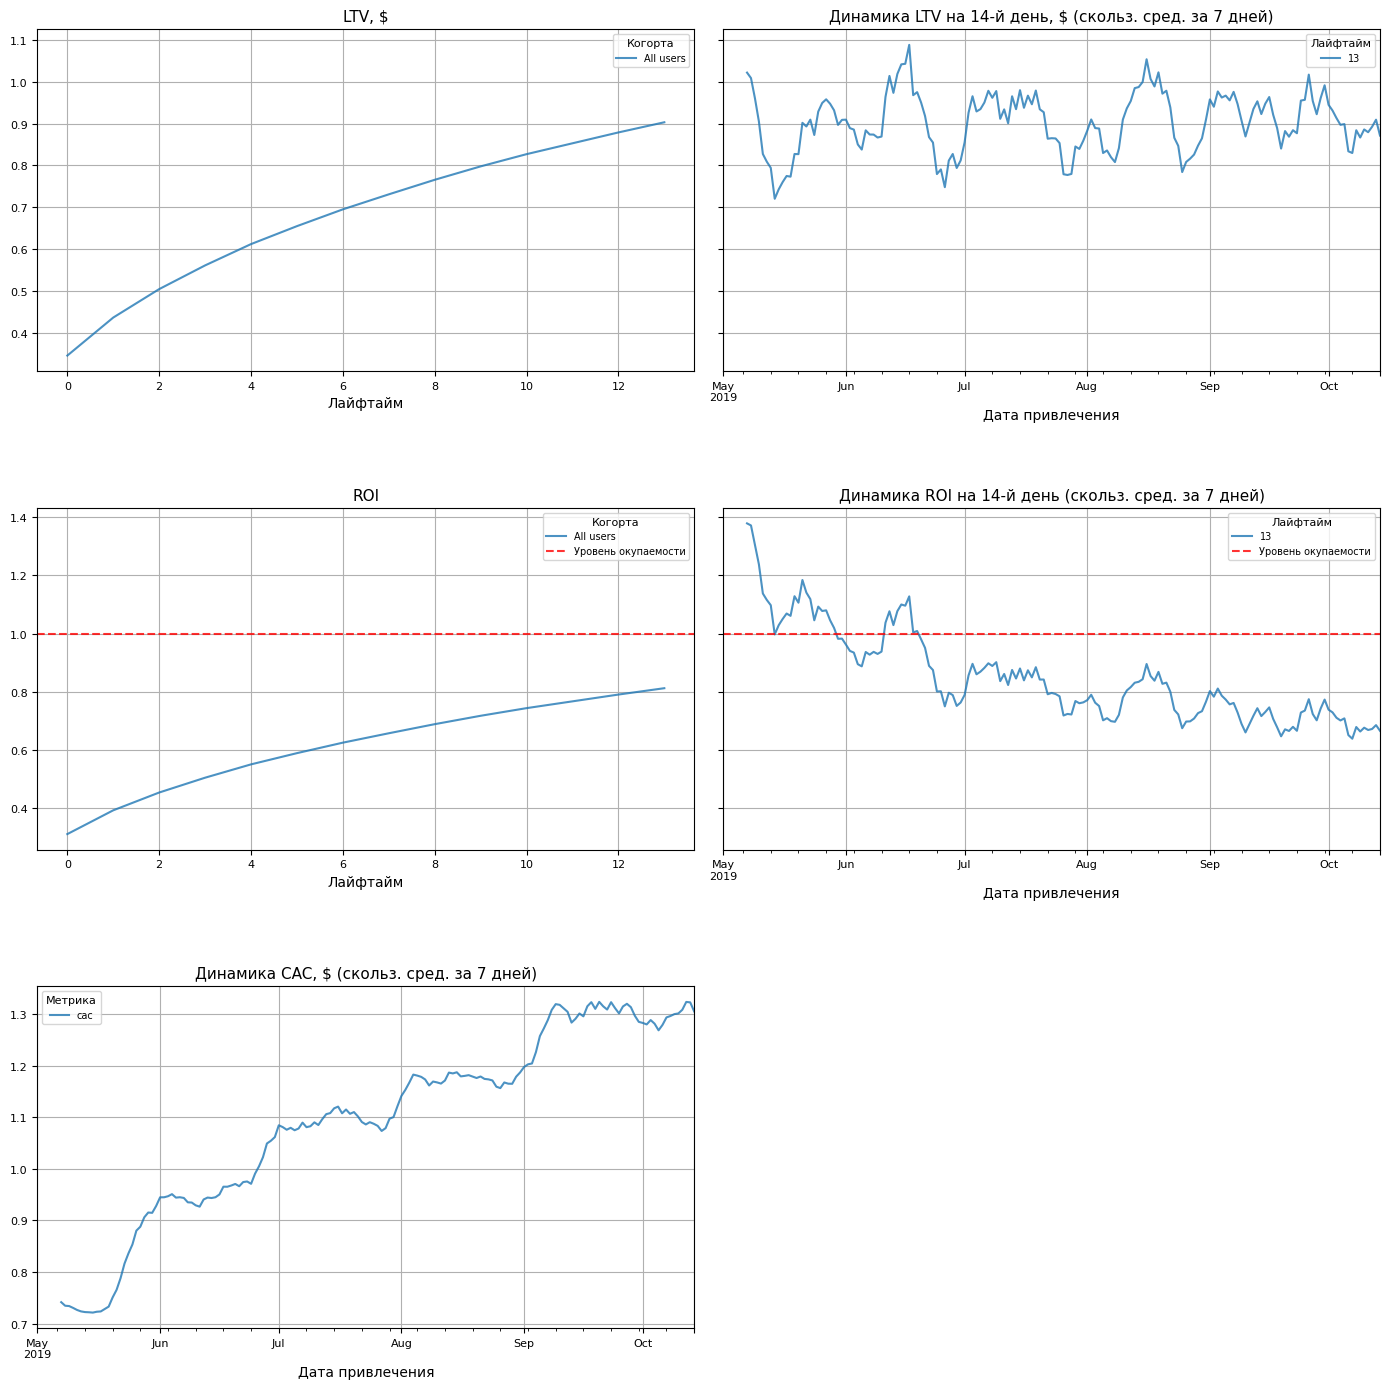

In [54]:
# посчитаем LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_organic_profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False)

# построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 7, 'Когорта', 'Лайфтайм', 'Метрика', 'дней')

<span style='font-weight: 600'>Исключив из анализа "органических" клиентов, сделаем следующие выводы:</span>

1. К концу второй недели <span style='font-weight: 600'>ROI</span> равен $81.1\%$. Реклама совсем не окупается;
2. Мы видим, как в мае относительно дёшево обходился пользователь <span style='font-weight: 600'>(CAC)</span>, при этом <span style='font-weight: 600'>ROI</span> поначалу был около $140\%$.\
   Затем, и до конца октября, <span style='font-weight: 600'>CAC</span> растёт с $0.74\$$ до $1.30\$$ за одного привлечённого пользователя, <span style='font-weight: 600'>LTV</span> $14$-го дня топчется +/- на одном и том же месте, а динамика <span style='font-weight: 600'>ROI</span> опускается с окупаемых $137\%$ до печальных $66.5\%$. \
Так как растёт <span style='font-weight: 600'>CAC</span> и <span style='font-weight: 600'>LTV</span> неизменный — <span style='font-weight: 600'>ROI</span> падает.
Интересно, что же было в начале мая и что у нас в конце октября?

In [55]:
roi

cohort_size       cac         0         1         2        3  \
cohort                                                                    
All users        86138  1.112235  0.310038  0.391846  0.453041  0.50404   

                  4         5         6         7         8         9  \
cohort                                                                  
All users  0.549894  0.588523  0.624634  0.656931  0.688231  0.717099   

                 10        11        12        13  
cohort                                             
All users  0.743392  0.766748  0.790117  0.811984

<br>

<br>

#### По устройствам

Проанализируем юнит-экономику по отдельным устройствам.

In [56]:
without_bad_channels_2 = profiles[~profiles['channel'].isin(['FaceBook', 'TikTok'])]

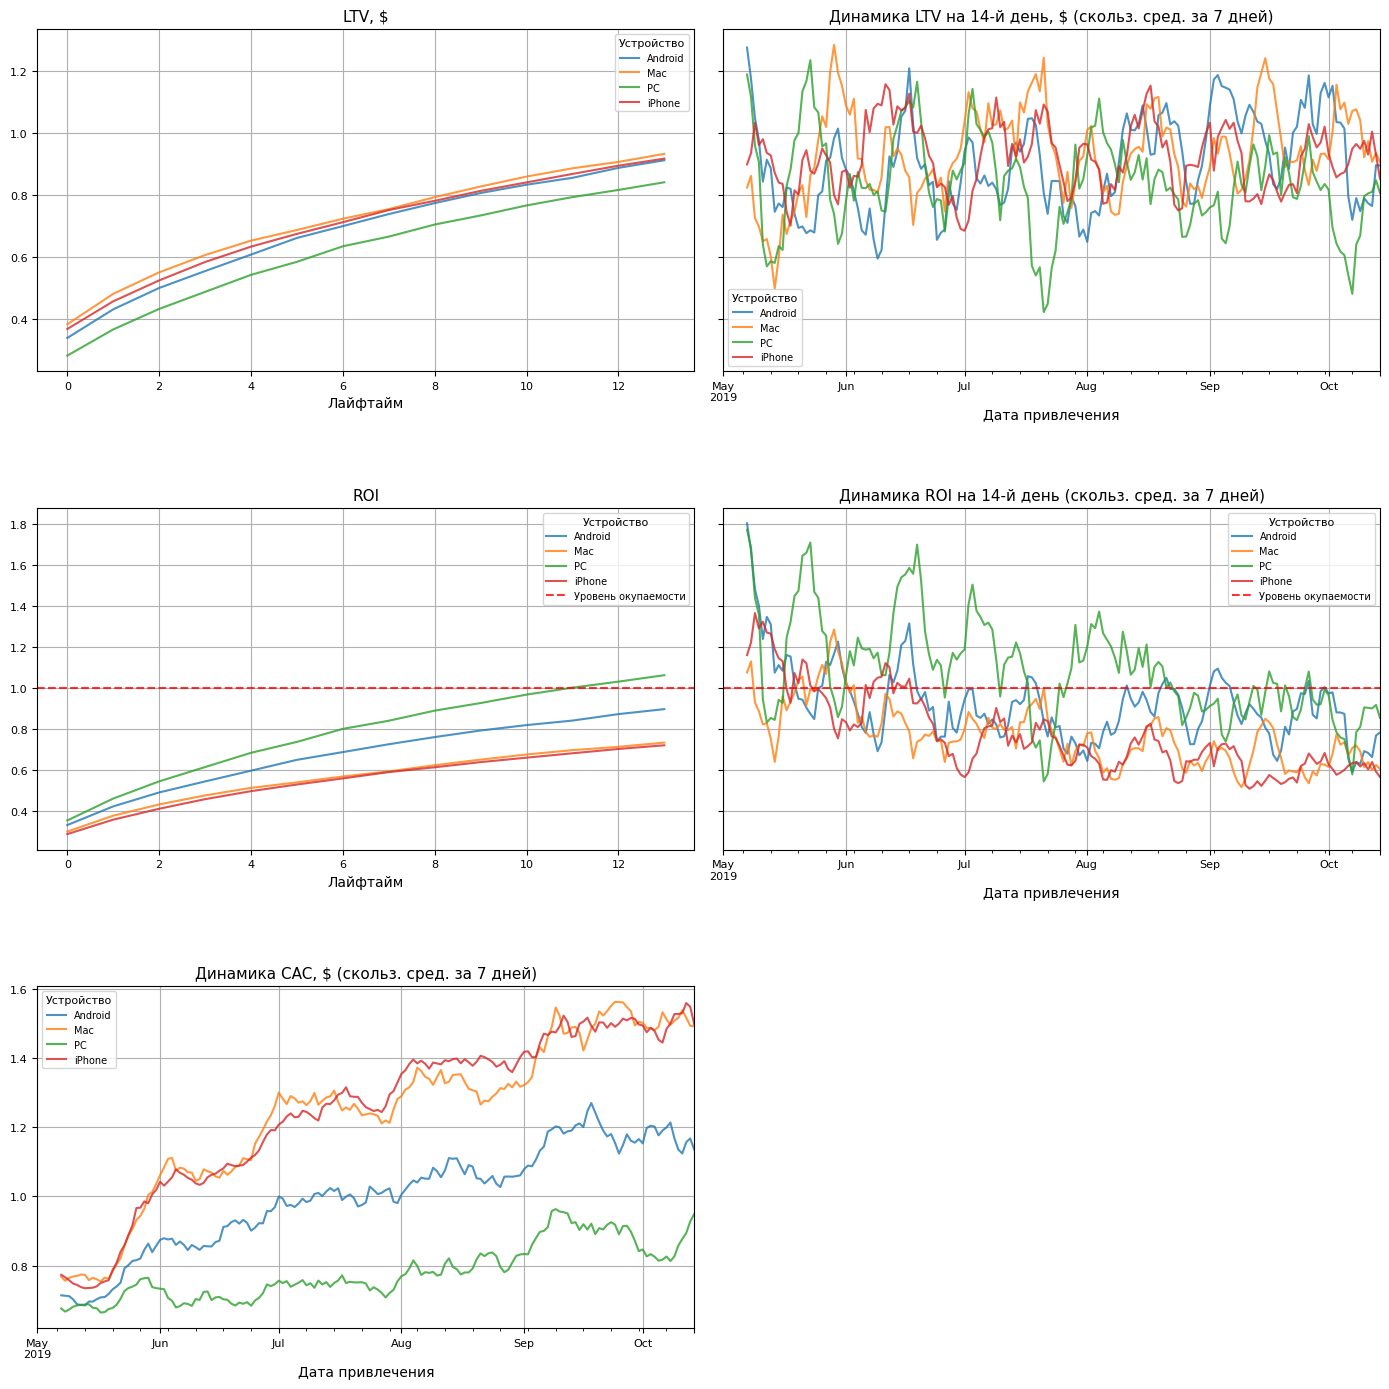

In [57]:
# посчитаем LTV, CAC, ROI в разрезе по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history = get_ltv(without_organic_profiles, orders, observation_date, horizon_days, dimensions=['device'])

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 7, 'Устройство', 'Устройство', 'Устройство', 'дней')

Только пользователи еле-еле `PC` окупаются, окупаться они начинают только с $12$-го дня, а их <span style='font-weight: 600'>ROI</span> на $14$-й день находится на отметке $106.3\%$.\
Пользователи `Android` и продукции `Apple` не окупаются, <span style='font-weight: 600'>ROI</span> пользователей `Android`, `iPhone` и `Mac` — $89.8\%$, $72.1\%$ и $73.4\%$, несмотря на то, что <span style='font-weight: 600'>LTV</span> этих трёх когорт выше <span style='font-weight: 600'>LTV</span> `PC`.

По динамике <span style='font-weight: 600'>ROI</span> видим, что окупаемость по всем устройствам с каждым месяцем становится всё хуже и хуже.

С каждым месяцем <span style='font-weight: 600'>CAC</span> растёт всё больше и больше.

<br>

<br>

#### По странам

Проанализируем юнит-экономику по отдельным странам.

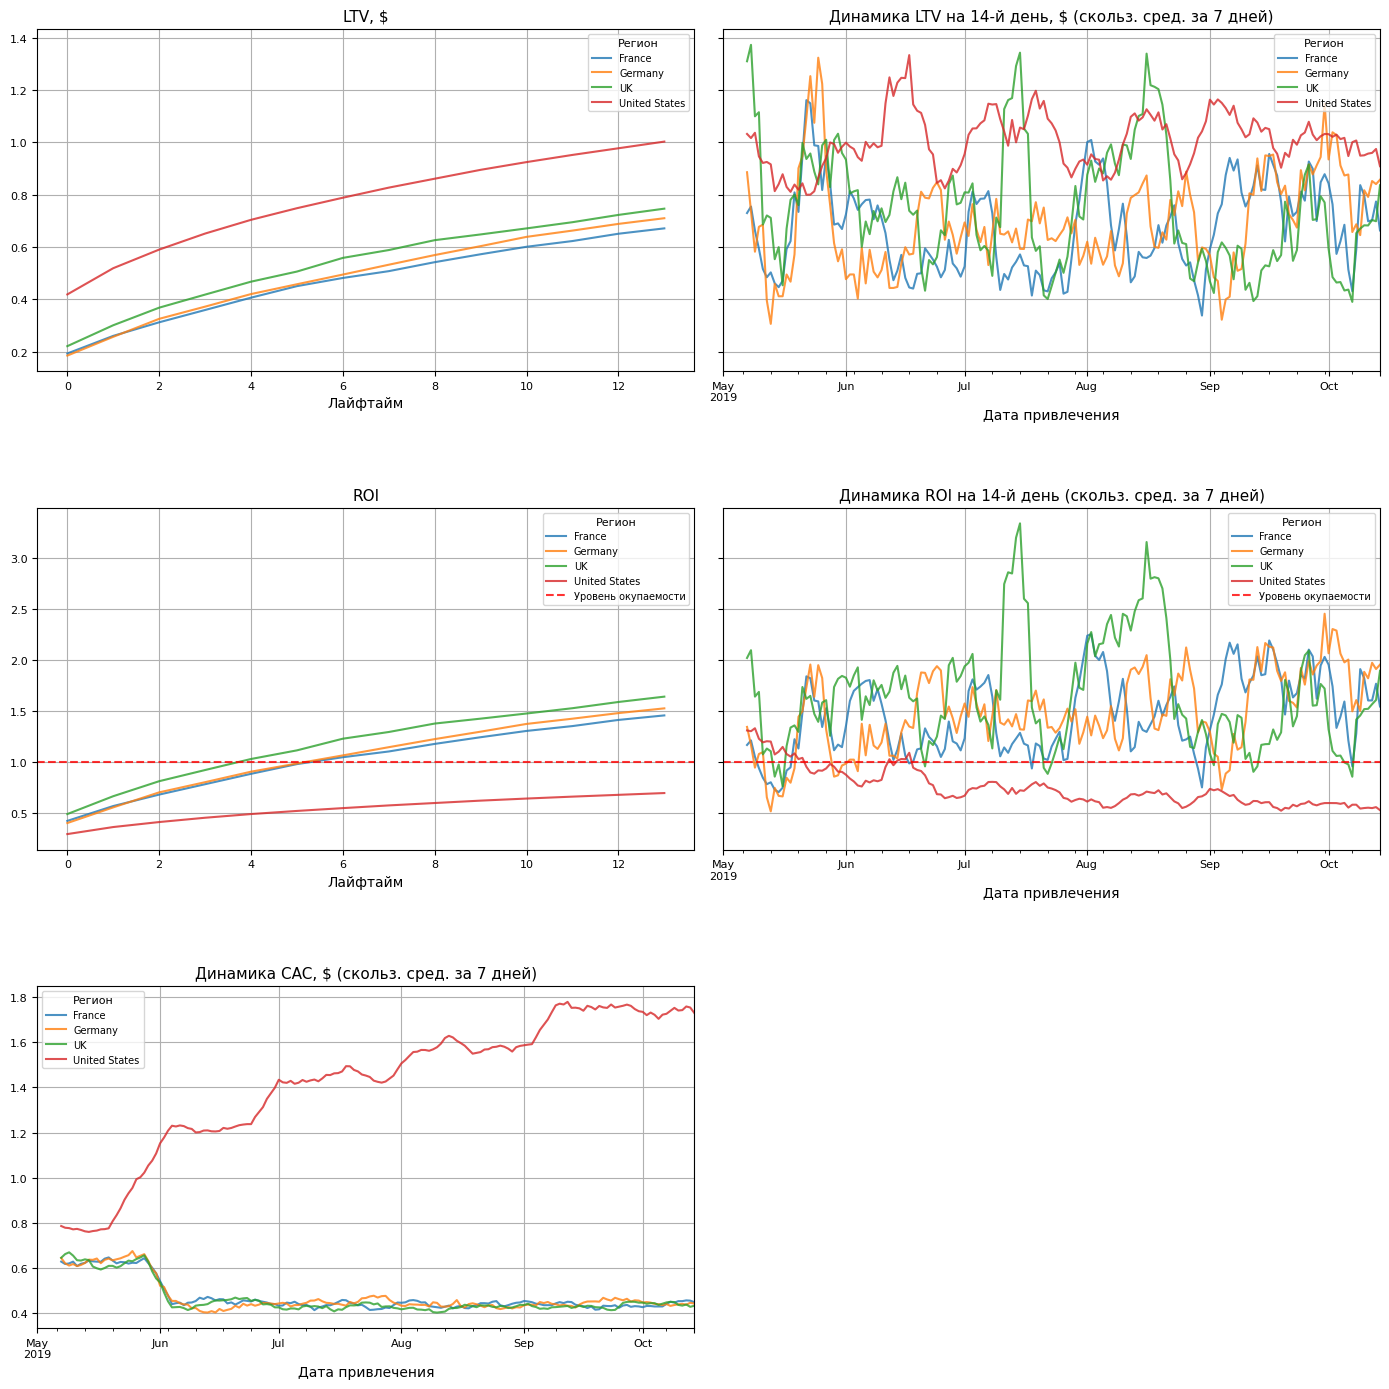

In [58]:
# посчитаем LTV, CAC, ROI в разрезе по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history = get_ltv(without_organic_profiles, orders, observation_date, horizon_days, dimensions=['region'])

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 7, 'Регион', 'Регион', 'Регион', 'дней')

Пользователи из `США` приносят больше всех дохода, но они совсем не окупаются, потому что очень дорого стоят, это видно на графике динамики стоимости привлечения.\
В них вся проблема. Нужно изучить этот регион подробнее.

А вот люди из `Великобритании` самые прибыльные.\
`Немцы` и `французы` тоже хорошо окупаются.

Средний рейтинг окупаемости регионов по состоянию на $14$-й день:
1. Великобритания — $164\%$
2. Германия — $152\%$
3. Франция — $145\%$
4. США — $69.2\%$

<br>

<br>

#### По рекламным каналам

Проанализируем юнит-экономику по отдельным каналам привлечения.

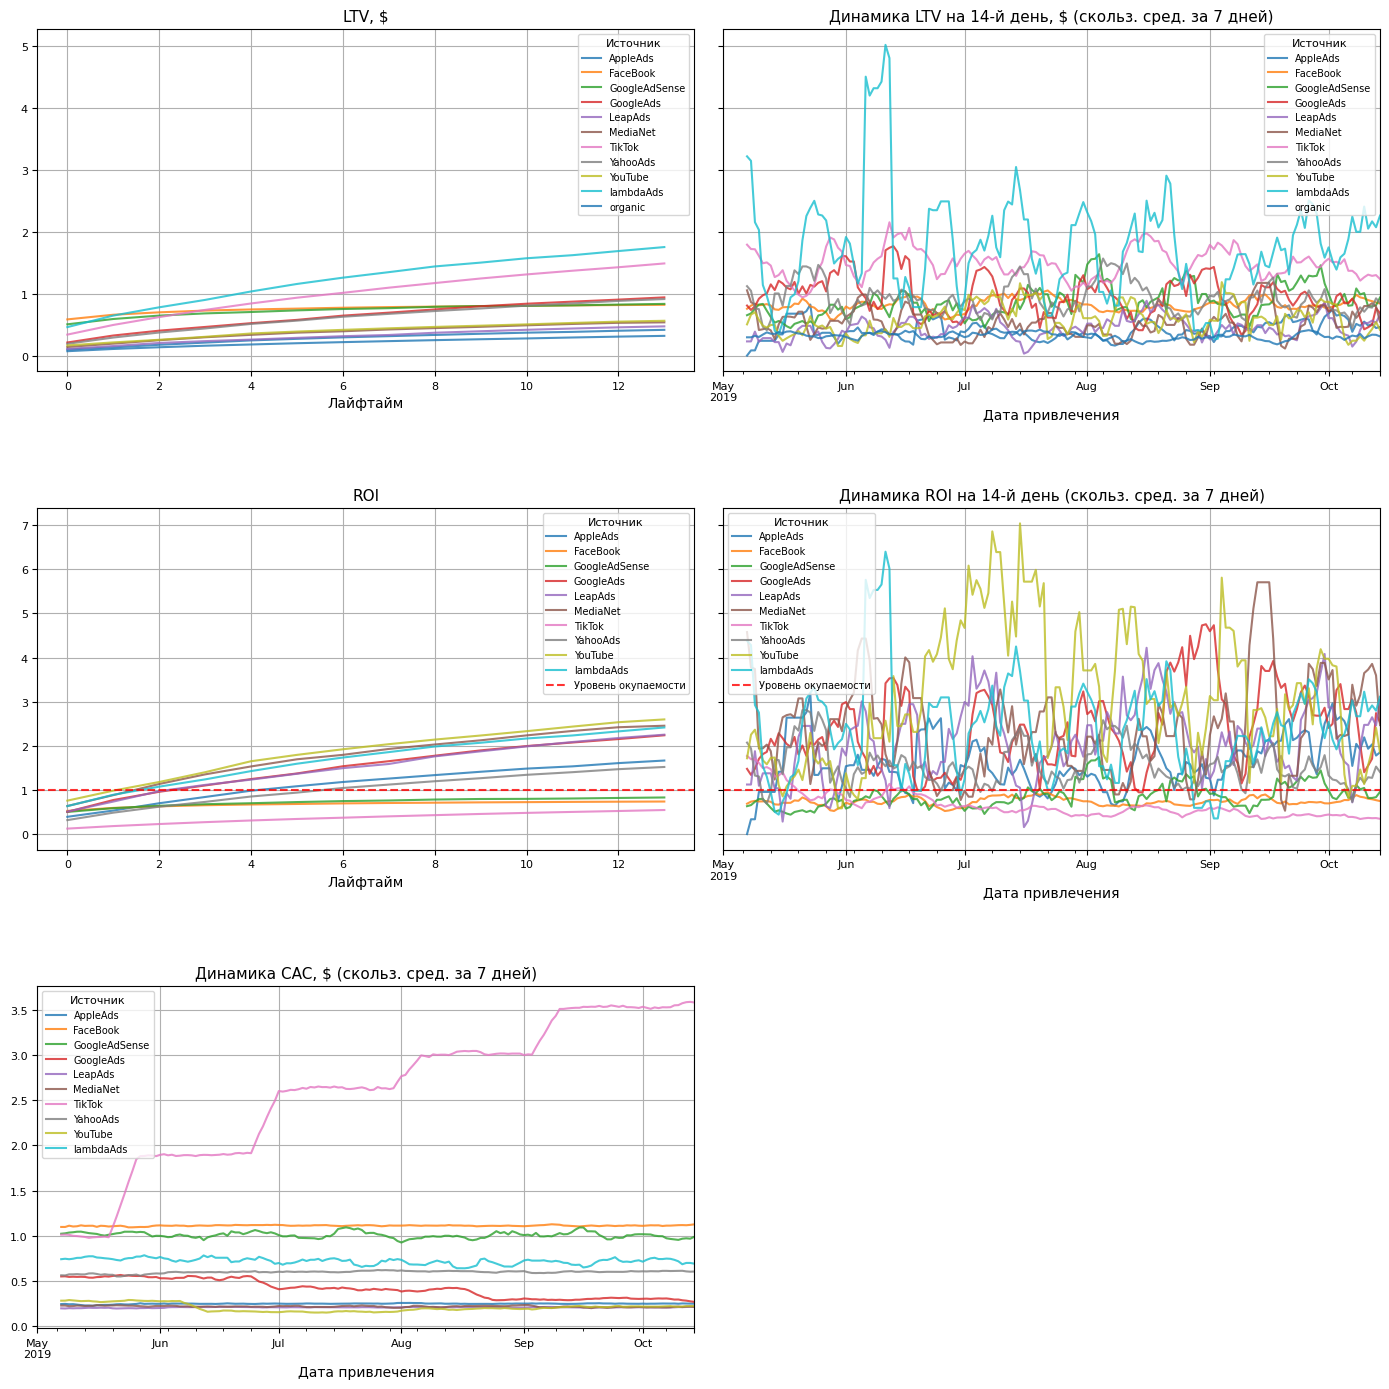

In [59]:
# посчитаем LTV, CAC, ROI в разрезе по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['channel'])

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 7, 'Источник', 'Источник', 'Источник', 'дней')

Выделяются самые доходные пользователи, с самым высоким <span style='font-weight: 600'>LTV</span>:
1. `lambdaAds` — $1.75$ $\$$
2. `TikTok` — $1.49$ $\$$

Следующие каналы привлечения не окупаются, потому что их <span style='font-weight: 600'>ROI</span> ниже $100\%$:
1. `TikTok` — $54.5\%$
2. `FaceBook` — $73.7\%$
3. `GoogleAdSense` — $82.9\%$

Самый окупаемый канал — `YouTube` с <span style='font-weight: 600'>ROI</span> $259.7\%$

Самым затратным каналом оказался `TikTok`, на графике динамики <span style='font-weight: 600'>CAC</span> он сильно выделяется, потому что стоимость пользователя подскочила с $1$ $\$$ до $3.58$ $\$$, в то время как по остальным каналом максимальная стоимость чуть-чуть превышает $1$ $\$$.

<br>

#### Что мешает получить прибыль?

Итак, реклама, направленная на привлечение пользователей, в целом не окупается, потому что <span style='font-weight: 600'>ROI</span> находится на отметке в $81.1\%$

Пользователи следующих когорт не окупаются, их <span style='font-weight: 600'>ROI</span> меньше $100\%$:
1. обладатели устройств `iPhone`, `Mac`, `Android`;
2. пользователи из `США`;
3. привлечённые из каналов `TikTok`, `GoogleAdSense`, `FaceBook`.

<br>

Рассчитаем юнит-экономику разом по всем регионам, устройствам, каналам.

In [60]:
# посчитаем LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_organic_profiles, orders, observation_date, horizon_days, dimensions=['region', 'device', 'channel'], ignore_horizon=False)

<br>

Запишем таблицу с окупаемостью в отельную переменную и установим новую колонку с булевым значением, означающую окупаемость по данному объекту.

In [61]:
# окупаемость
all_the_dims_roi = roi
# булево значение
all_the_dims_roi['is_profit'] = all_the_dims_roi[13] >= 1

<br>

Сделаем сводную таблицу со статистикой окупаемости рекламных каналов.

In [62]:
# сводная таблица
channel_stats = all_the_dims_roi.groupby('channel').agg(values=('is_profit', 'count'),
                                                        paid_off=('is_profit', 'sum'))
# колонка с кол-вом неокупаемых
channel_stats['unprofitable'] = channel_stats['values'] - channel_stats['paid_off']

# сортировка
channel_stats.sort_values(by='unprofitable', ascending=False)

values  paid_off  unprofitable
channel                                      
GoogleAdSense      12         2            10
FaceBook            4         0             4
TikTok              4         0             4
AppleAds           12        11             1
YahooAds           12        11             1
GoogleAds           4         4             0
LeapAds            12        12             0
MediaNet            4         4             0
YouTube             4         4             0
lambdaAds          12        12             0

Встречаются $5$ рекламных источников, которые не окупались.\
В случае $3$-х из них ситуация очень плохая:
* Источники `FaceBook` и `TikTok` никогда не окупались;
* `GoogleAdSense` не окупался в $10$ из $12$ случаев.

Именно в этих трёх каналах пользователи и не окупались.\
С ними нужно работать.

<br>

<br>

Посмотрим срез по `FaceBook` и `TikTok`.

In [63]:
all_the_dims_roi.query('channel == ["FaceBook", "TikTok"]').sort_values(by=13, ascending=False)

cohort_size       cac         0         1  \
region        device  channel                                               
United States Android FaceBook         5400  1.113781  0.591000  0.662852   
              Mac     FaceBook         6678  1.113655  0.544938  0.616209   
              PC      FaceBook         2751  1.113781  0.461274  0.538174   
              iPhone  FaceBook        11907  1.113579  0.499722  0.561222   
              Android TikTok           3564  2.725571  0.130284  0.200467   
              PC      TikTok           1844  2.759403  0.138491  0.190469   
              iPhone  TikTok           8118  2.723446  0.124466  0.178193   
              Mac     TikTok           4427  2.747479  0.112503  0.167730   

                                       2         3         4         5  \
region        device  channel                                            
United States Android FaceBook  0.698701  0.719609  0.737032  0.746990   
              Mac     FaceBook  0.651905  0.678086  0.689493  0.702912   
              PC      FaceBook  0.577269  0.609841  0.626127  0.637527   
              iPhone  FaceBook  0.594644  0.620235  0.639059  0.651478   
              Android TikTok    0.256061  0.299417  0.348336  0.408254   
              PC      TikTok    0.244015  0.296999  0.342707  0.370166   
              iPhone  TikTok    0.222076  0.262707  0.298372  0.328707   
              Mac     TikTok    0.208515  0.249714  0.280156  0.303540   

                                       6         7         8         9  \
region        device  channel                                            
United States Android FaceBook  0.762754  0.777039  0.786166  0.792140   
              Mac     FaceBook  0.717675  0.726532  0.734588  0.743981   
              PC      FaceBook  0.655442  0.666842  0.673356  0.679870   
              iPhone  FaceBook  0.660962  0.667736  0.672704  0.680234   
              Android TikTok    0.435586  0.467024  0.499191  0.536186   
              PC      TikTok    0.405667  0.437245  0.465097  0.487851   
              iPhone  TikTok    0.359046  0.392503  0.416744  0.440490   
              Mac     TikTok    0.327748  0.351627  0.380517  0.407678   

                                      10        11        12        13  \
region        device  channel                                            
United States Android FaceBook  0.797118  0.802096  0.805414  0.807074   
              Mac     FaceBook  0.747336  0.752033  0.754046  0.758743   
              PC      FaceBook  0.691270  0.697785  0.699413  0.705928   
              iPhone  FaceBook  0.684451  0.690473  0.698006  0.701393   
              Android TikTok    0.561871  0.585501  0.610676  0.637903   
              PC      TikTok    0.517271  0.543162  0.563756  0.588668   
              iPhone  TikTok    0.461932  0.483735  0.504550  0.524143   
              Mac     TikTok    0.432871  0.451990  0.468401  0.491457   

                                is_profit  
region        device  channel              
United States Android FaceBook      False  
              Mac     FaceBook      False  
              PC      FaceBook      False  
              iPhone  FaceBook      False  
              Android TikTok        False  
              PC      TikTok        False  
              iPhone  TikTok        False  
              Mac     TikTok        False

Здесь только `США`, именно этот регион у нас не окупался.

<br>

Посмотрим срез по `GoogleAdSense`.

In [64]:
all_the_dims_roi.query('channel == ["GoogleAdSense"]').sort_values(by=13, ascending=False)

cohort_size       cac         0         1  \
region  device  channel                                                    
Germany iPhone  GoogleAdSense          232  1.000177  0.667037  0.796066   
UK      PC      GoogleAdSense          510  1.010092  0.742235  0.860415   
Germany PC      GoogleAdSense          464  1.009783  0.577241  0.673156   
France  Mac     GoogleAdSense          137  1.009244  0.360897  0.433077   
Germany Android GoogleAdSense          307  1.014059  0.416747  0.512919   
France  PC      GoogleAdSense          496  1.007352  0.491508  0.561417   
        Android GoogleAdSense          381  1.007161  0.431816  0.483832   
UK      iPhone  GoogleAdSense          248  1.004631  0.280395  0.400564   
        Android GoogleAdSense          334  1.005347  0.431078  0.505381   
France  iPhone  GoogleAdSense          270  1.009762  0.497844  0.538117   
UK      Mac     GoogleAdSense          115  1.013861  0.350961  0.436557   
Germany Mac     GoogleAdSense          133  1.001884  0.337034  0.374482   

                                      2         3         4         5  \
region  device  channel                                                 
Germany iPhone  GoogleAdSense  0.839075  0.882085  0.946599  0.968104   
UK      PC      GoogleAdSense  0.899161  0.918534  0.937907  0.966967   
Germany PC      GoogleAdSense  0.737057  0.769007  0.769007  0.779657   
France  Mac     GoogleAdSense  0.505256  0.613526  0.685705  0.685705   
Germany Android GoogleAdSense  0.577034  0.625120  0.657178  0.689235   
France  PC      GoogleAdSense  0.601385  0.621359  0.631346  0.653322   
        Android GoogleAdSense  0.574860  0.600868  0.613872  0.691974   
UK      iPhone  GoogleAdSense  0.500705  0.560790  0.600846  0.640903   
        Android GoogleAdSense  0.549963  0.594545  0.609406  0.609406   
France  iPhone  GoogleAdSense  0.556420  0.574723  0.593026  0.629631   
UK      Mac     GoogleAdSense  0.479356  0.564952  0.564952  0.564952   
Germany Mac     GoogleAdSense  0.411930  0.411930  0.456883  0.456883   

                                      6         7         8         9  \
region  device  channel                                                 
Germany iPhone  GoogleAdSense  0.968104  0.989609  1.054124  1.054124   
UK      PC      GoogleAdSense  1.015399  1.034773  1.063832  1.073519   
Germany PC      GoogleAdSense  0.811607  0.822257  0.896872  0.928823   
France  Mac     GoogleAdSense  0.721795  0.721795  0.721795  0.793974   
Germany Android GoogleAdSense  0.721292  0.737321  0.753350  0.769379   
France  PC      GoogleAdSense  0.663309  0.673296  0.683283  0.683283   
        Android GoogleAdSense  0.691974  0.717982  0.717982  0.730986   
UK      iPhone  GoogleAdSense  0.660931  0.660931  0.660931  0.680959   
        Android GoogleAdSense  0.639127  0.668849  0.683709  0.683709   
France  iPhone  GoogleAdSense  0.629631  0.629631  0.629631  0.629631   
UK      Mac     GoogleAdSense  0.607750  0.607750  0.607750  0.607750   
Germany Mac     GoogleAdSense  0.456883  0.456883  0.456883  0.456883   

                                     10        11        12        13  \
region  device  channel                                                 
Germany iPhone  GoogleAdSense  1.054124  1.075628  1.118638  1.118638   
UK      PC      GoogleAdSense  1.073519  1.083205  1.083205  1.092892   
Germany PC      GoogleAdSense  0.928823  0.928823  0.960773  0.971423   
France  Mac     GoogleAdSense  0.793974  0.793974  0.830064  0.830064   
Germany Android GoogleAdSense  0.769379  0.769379  0.769379  0.769379   
France  PC      GoogleAdSense  0.695272  0.695272  0.705259  0.755254   
        Android GoogleAdSense  0.730986  0.743990  0.743990  0.743990   
UK      iPhone  GoogleAdSense  0.680959  0.700987  0.700987  0.700987   
        Android GoogleAdSense  0.683709  0.683709  0.698570  0.698570   
France  iPhone  GoogleAdSense  0.629631  0.666237  0.666237  0.666237   
UK      Mac     GoogleAdSense  0.607750  0.6

`GoogleAdSense` еле-еле окупается в $2$ случаях из $12$.

<br>

Сделаем сводную таблицу, отображающую:
* регион;
* канал;
* кол-во пользователей по данному региону и каналу;
* процент пользователей по данному региону и каналу;
* кол-во пользователей по данному региону.

In [65]:
# сводная таблица
reg_chan_users = all_the_dims_roi.groupby(['region', 'channel'])\
                                 .agg(users=('cohort_size', 'sum'))\
                                 .reset_index()

# кол-во пользователей по данному региону
reg_chan_users['reg_users'] = reg_chan_users.groupby('region')['users'].transform('sum')
# сортировка
reg_chan_users = reg_chan_users.sort_values(by=['reg_users', 'users'], ascending=False)
# процент пользователей по данному региону и каналу
reg_chan_users['user_perc'] = (reg_chan_users['users'] / reg_chan_users['reg_users'] * 100).round(1)
# порядок отображения колонок
reg_chan_users = reg_chan_users[['region', 'channel', 'users', 'user_perc', 'reg_users']]

reg_chan_users

region        channel  users  user_perc  reg_users
15  United States       FaceBook  26736       47.0      56902
18  United States         TikTok  17953       31.6      56902
16  United States      GoogleAds   4142        7.3      56902
17  United States       MediaNet   4081        7.2      56902
19  United States        YouTube   3990        7.0      56902
12             UK        LeapAds   2810       27.5      10232
10             UK       AppleAds   2787       27.2      10232
13             UK       YahooAds   2720       26.6      10232
11             UK  GoogleAdSense   1207       11.8      10232
14             UK      lambdaAds    708        6.9      10232
2          France        LeapAds   2757       27.0      10217
3          France       YahooAds   2742       26.8      10217
0          France       AppleAds   2739       26.8      10217
1          France  GoogleAdSense   1284       12.6      10217
4          France      lambdaAds    695        6.8      10217
8         Germany       YahooAds   2370       27.0       8787
5         Germany       AppleAds   2364       26.9       8787
7         Germany        LeapAds   2308       26.3       8787
6         Germany  GoogleAdSense   1136       12.9       8787
9         Germany      lambdaAds    609        6.9       8787

Получается, что $44$ $689$ пользователей $(78.6\%)$ среди всех пользователей `США` пришли из убыточных каналов `FaceBook` и `TikTok`.\
В Европе же ситуация по пришедшим пользователям по убыточному каналу `GoogleAdSense` в процентах следующая:
* В `Великобритании` — $1$ $207$ юзеров, $11.8\%$ от всех из `Великобритании`;
* Во `Франции` — $1$ $284$ юзера, $12.6\%$ от всех из `Франции`;
* В `Германии` — $1$ $136$ юзеров, $12.9\%$ от всех из `Германии`.

Все эти проценты составляют $48$ $316$ пользователей $(56.1\%)$ из $86$ $138$ привлечённых.\
И в остальных, окупающихся каналах, содержится $37$ $822$ $(43.9\%)$ пользователей.

<br>

В нашей ситуации столько $\$$ принесли все $86$ $138$ пользователей за $14$ дней существования в когортах.

In [66]:
income = round(ltv_raw[ltv_raw['lifetime'] < 14]['revenue'].sum())
income

77793

<br>

И столько затрачено на их привлечение.

In [67]:
cost = round(ltv_raw[~ltv_raw['user_id'].duplicated()]['acquisition_cost'].sum())
cost

95806

<br>

Разница доходов и расходов.

In [68]:
income - cost

-18013

На $14$-й день жизни всех когорт мы в минусе на $18$ $013$ $\$$.\
Получается, у нас целая куча пользователей, $86$ $138$, которые не окупаются.

<br>

И что будет, если из рассчёта юнит-экономики вырезать эти три убыточных канала?

In [69]:
# исключим три убыточных канала
without_bad_channels = without_organic_profiles[~without_organic_profiles['channel'].isin(['FaceBook', 'TikTok', 'GoogleAdSense'])]

<br>

Посмотрим общий <span style='font-weight: 600'>ROI</span>, <span style='font-weight: 600'>ROI</span> в разбивке по устройствам, странам, каналам без этих трёх убыточных каналов.

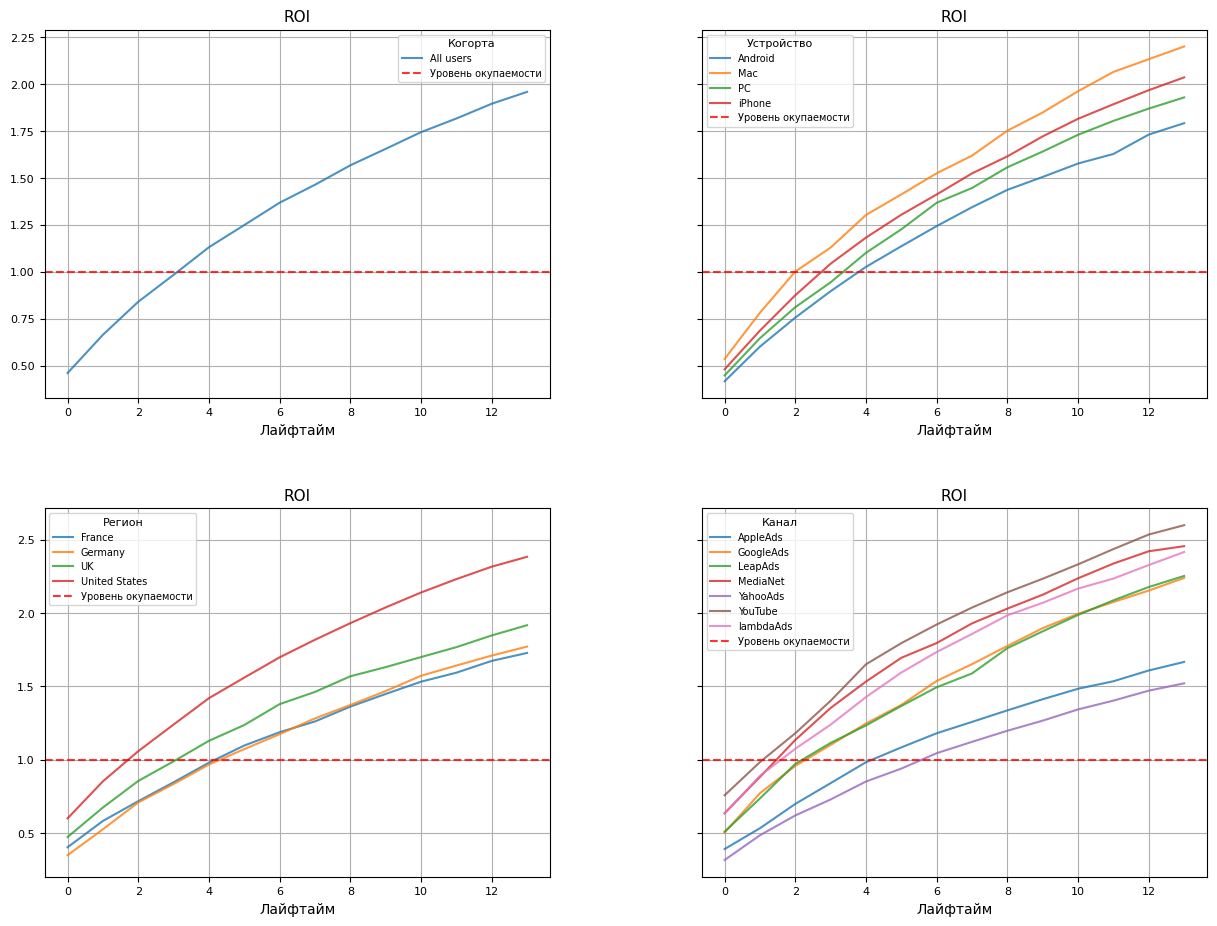

In [76]:
# задаём сетку отрисовки графиков
plt.figure(figsize=(15, 11))

# по всем пользователям
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_bad_channels, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False)

ax1 = plt.subplot(2, 2, 1)
roi.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, ax=ax1, alpha=0.8)
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
plt.xlabel('Лайфтайм')
plt.title('ROI', fontsize=11)
plt.tick_params(axis='both', which='both', labelsize=8)
plt.legend(title='Когорта', title_fontsize=8, fontsize=7)

# по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_bad_channels, orders, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False)

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
roi.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, ax=ax2, alpha=0.8)
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
plt.xlabel('Лайфтайм')
plt.title('ROI', fontsize=11)
plt.tick_params(axis='both', which='both', labelsize=8)
plt.legend(title='Устройство', title_fontsize=8, fontsize=7)

# по регионам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_bad_channels, orders, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False)

ax3 = plt.subplot(2, 2, 3)
roi.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, ax=ax3, alpha=0.8)
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
plt.xlabel('Лайфтайм')
plt.title('ROI', fontsize=11)
plt.tick_params(axis='both', which='both', labelsize=8)
plt.legend(title='Регион', title_fontsize=8, fontsize=7)

# по каналам
ltv_raw, ltv, ltv_history, roi, roi_history, cac, cac_history  = get_ltv(without_bad_channels, orders, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False)

ax4 = plt.subplot(2, 2, 4, sharey=ax3)
roi.drop(columns=['cohort_size', 'cac']).T.plot(grid=True, ax=ax4, alpha=0.8)
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости', alpha=0.8)
plt.xlabel('Лайфтайм')
plt.title('ROI', fontsize=11)
plt.tick_params(axis='both', which='both', labelsize=8)
plt.legend(title='Канал', title_fontsize=8, fontsize=7)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Генеральный <span style='font-weight: 600'>ROI</span>, на первом графике, равен $195\%$. Теперь реклама полностью окупается и приносит прибыль.\
Также по всем устройствам, регионам, каналам реклама приносит прибыль.

<br>

Сколько же $\$$ принесли $37$ $822$ пользователей из $7$ прибыльных каналов за $14$ дней существования?

In [71]:
good_income = round(ltv_raw[ltv_raw['lifetime'] < 14]['revenue'].sum())
good_income

26043

<br>

И сколько затрачено на их привлечение.

In [72]:
good_cost = round(ltv_raw[~ltv_raw['user_id'].duplicated()]['acquisition_cost'].sum())
good_cost

13301

<br>

Разница доходов и расходов.

In [73]:
good_income - good_cost

12742

На $14$-й день жизни всех когорт мы в плюсе на $12$ $742$ $\$$.\
Эти $37$ $822$ пользователя дают нам такую прибыль.

<br>

Таким образом, причины неэффективности привлечения пользователей кроются в каналах `FaceBook` и `TikTok` для `США` и `GoogleAdSense` для `Европы`.\
Следовательно, глобальная рекомендация для отдела маркетинга такова, что нужно:
1. для `США`:
    1. перестать закупать трафик из каналов `FaceBook` и `TikTok`;
    2. начать привлекать пользователей из каналов `MediaNet`, `YouTube`, `GoogleAds`.
2. для `Европы`:
    1. перестать закупать трафик из канала `GoogleAdSense`;
    2. начать привлекать пользователей из каналов `LeapAds`, `AppleAds`, `YahooAds`, `lambdaAds`.

<br>

<br>

<br>

<br>

### Выводы

#### Исследовательский анализ данных

Прежде всего мы определили рассматриваемый промежуток времени.\
Он выражен минимальной и максимальной датой привлечения пользователей: `2019-05-01` — `2019-10-27`.\
Анализируем данные за это время.

Узнали самых платежеспособных пользователей в разбивке по разным критериям: регионам, устройствам, каналам привлечения.

Всего $150$ $008$ пользователей.

<span style='font-weight: 600'>Регионы.</span>\
$66.6\%$ находятся в `США`, это $100$ $002$ человека. Они являются самыми платежеспособными, так как у них самый большой процент платежеспособных среди всех стран — $6.9\%$, это $6$ $902$ человека.

<span style='font-weight: 600'>Устройства.</span>\
Преобладают владельцы `iPhone`, их $36.3\%$, это $54$ $479$ людей, кол-во платежеспособных там больше всех, $3$ $382$ человека, $6.21\%$.\
Но процент платежеспособных людей больше всего там, где `Mac` — $6.36\%$.

<span style='font-weight: 600'>Каналы привлечения.</span>\
Больше всего пользователей из `органического` канала, они пришли сами по себе: $56$ $439$ $(37.6\%)$. Но процент платежеспособных у них — минимальный $(2.06\%)$\
Самые высокие проценты платящих пользователей в каналах: `FaceBook` $(12.2\%)$, `GoogleAdSense` $(11.34\%)$, `lambdaAds` $(10.47\%)$\
`Органические` пользователи, пользователи из источников `FaceBook` и `TikTok` втроём вместе составляют $70\%$ всего трафика ($105$ $144$ человека)

Всего на маркетинг было затрачено $105$ $497$ $\$$.

Более $80\%$ рекламного бюджета было вложено в источники:
1. `TikTok` — $54$ $751$ $\$$ $(51.9\%)$
2. `FaceBook` — $32$ $445$ $\$$ $(30.75\%)$

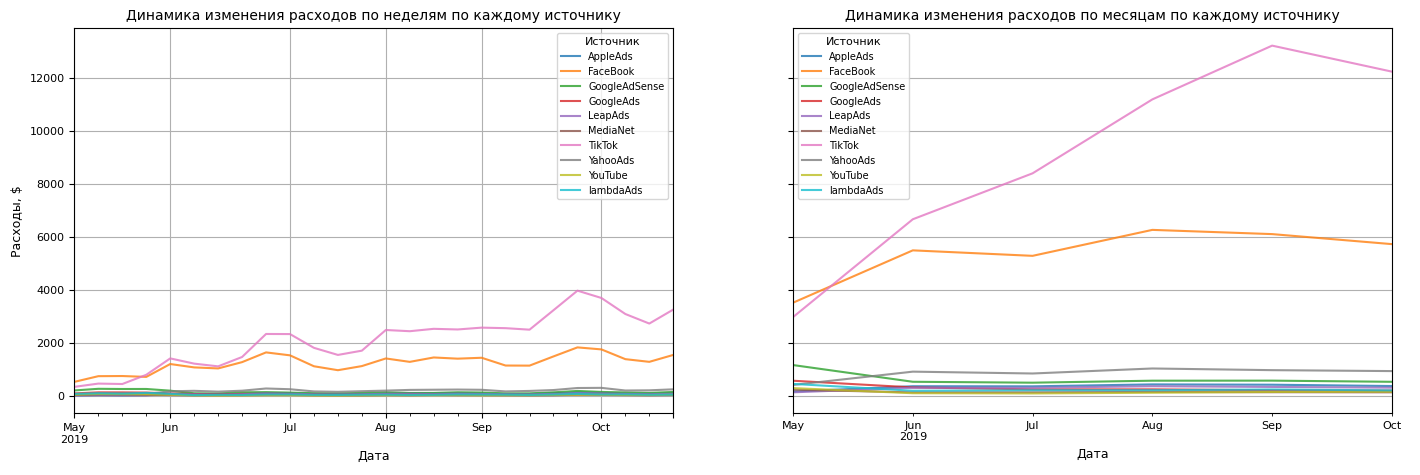

Начиная с июня $2019$ года, расходы на рекламу по источнику `FaceBook` находятся примерно на одном уровне, около $6$ $000$ долларов в месяц, или около $1000-1500$ долларов в неделю.

Расходы по источнику `TikTok` с мая имеют восходящий тренд, каждый месяц траты на рекламу по этому источнику растут.\
Лишь в конце сентября траты по этому источнику убавились.

Может, имеет смысл попробовать вкладываться в рекламу по `lambdaAds` и `GoogleAdSense`? Процент платящих пользователей от них выше, чем от `TikTok`.

В среднем самый дорогой пользователь — из канала `TikTok` $(2,8$ $\$)$, в то время как средний показатель <span style='font-weight: 600'>CAC</span> вне зависимости от источника — $0.69$ $\$$.\
Всего $4$ канала выше среднего показателя <span style='font-weight: 600'>CAC</span>.
1. TikTok — $2.80$ $\$$
2. FaceBook	— $1.11$ $\$$
3. GoogleAdSense — $1.01$ $\$$
4. lambdaAds — $0.72$ $\$$

<br>

<br>

#### Удержание и конверсия

Когортный анализ показал, как меняются: удержание, конверсия, пожизненная стоимость, стоимость привлечения, окупаемость пользователей в зависимости от устройства, страны, рекламного канала.

Считаем, что на календаре дата, равная самой поздней дате первого посещения, то есть `2019-10-27`. <span style='font-weight: 600'>Это момент анализа.</span>\
А в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через $2$ недели после привлечения. <span style='font-weight: 600'>Это горизонт анализа.</span>

1. Отобразили графики <span style='font-weight: 600'>Retention Rate</span>, <span style='font-weight: 600'>Conversion Rate</span>, графики динамики <span style='font-weight: 600'>Retention Rate</span>, <span style='font-weight: 600'>Conversion Rate</span> в разрезе по:
   1. в общем;
   2. устройствам;
   3. странам;
   4. рекламным каналам.

Рассчитали юнит-экономику, то есть узнали, окупаются ли привлечённые пользователи:

2. Отобразили графики <span style='font-weight: 600'>LTV</span> и <span style='font-weight: 600'>ROI</span>, графики динамики <span style='font-weight: 600'>LTV</span>, <span style='font-weight: 600'>CAC</span> и <span style='font-weight: 600'>ROI</span> в разрезе по:
    * в общем;
    * устройствам;
    * странам;
    * рекламным каналам.

<br>

##### Удержание и конверсия

<span style='font-weight: 600'>По всем пользователям</span>

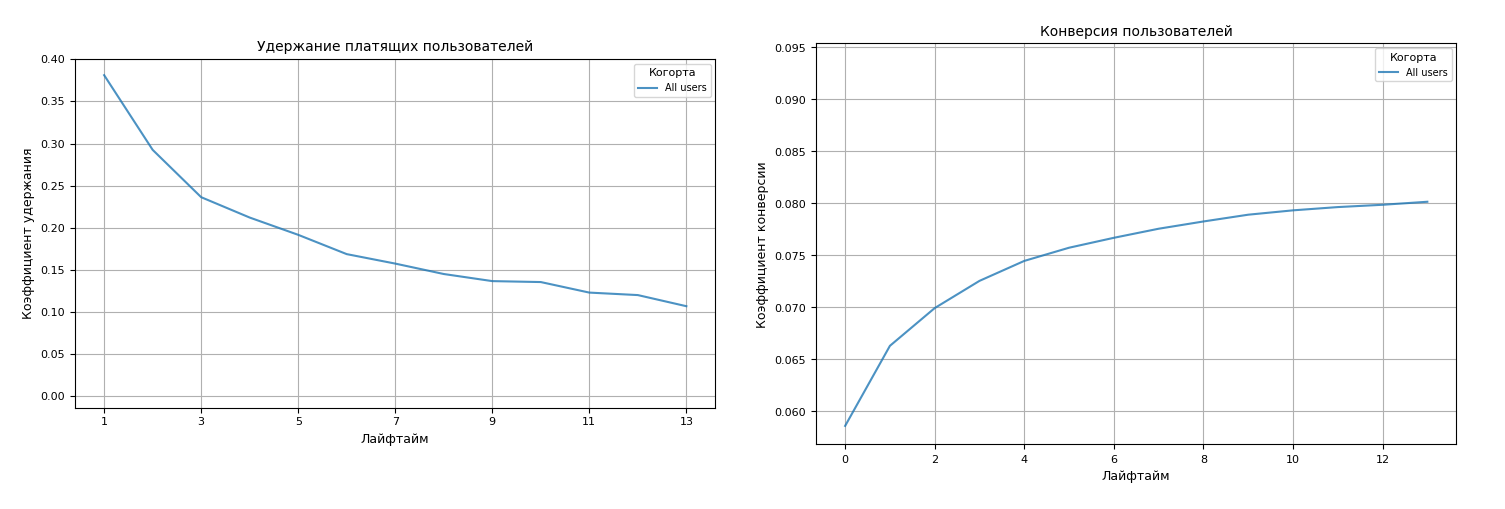

Кривые показывают, что:
1. $10.64\%$ из тех, кто заплатил, вернулись к $14$-му дню.
2. Конверсия к концу второй недели равна $8.0\%$.

<br>

<span style='font-weight: 600'>По устройствам</span>

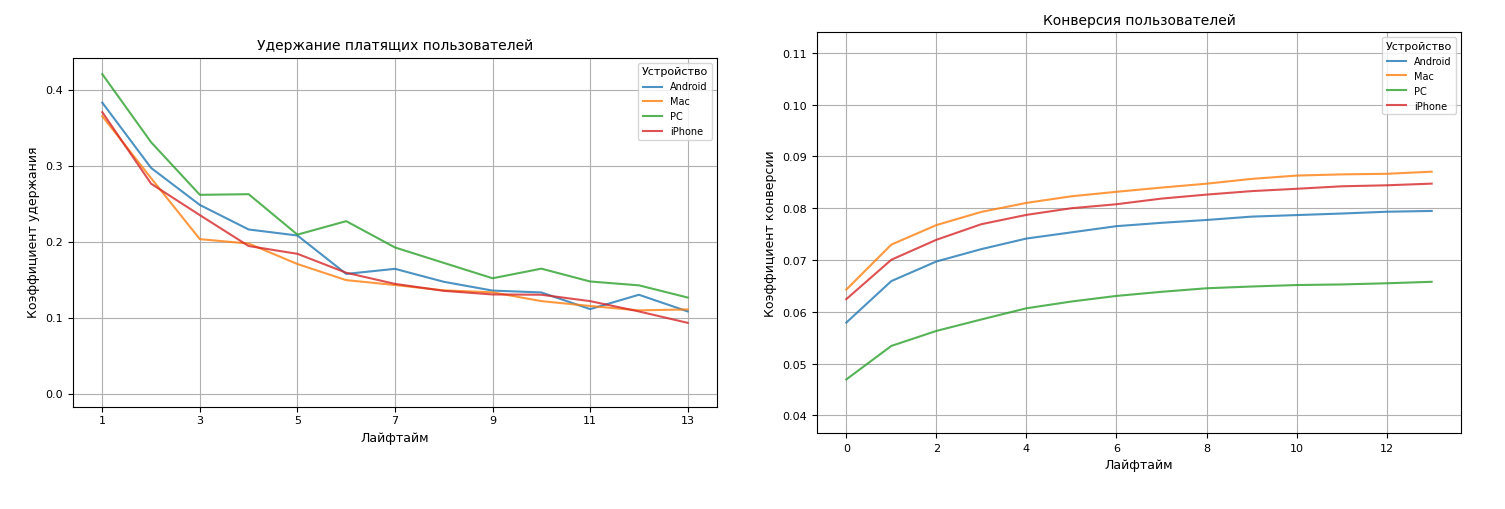

Среди платящих больше всего получается удерживать владельцев `ПК`.\
Их уровень удержания на $14$-й день находится на отметке $12.69\%$.

Самая высокая средняя конверсия на $14$-й день — у владельцев `Mac` и `iPhone` — $8.7\%$ и $8.4\%$\
`PC` пользователи конвертируются в покупатели хуже всех — $6.5\%$.

<br>

<span style='font-weight: 600'>По странам</span>

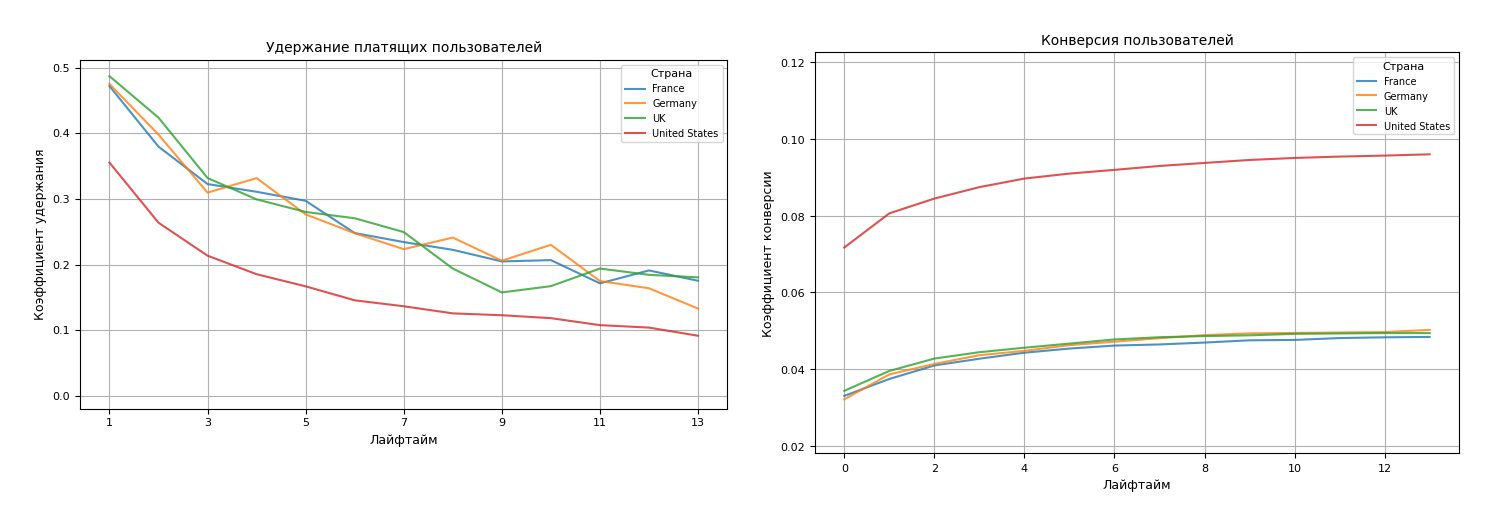

Удержание платящих пользователей `США` находится ниже пользователей других стран — на уровне $9.1\%$.\
Лидерами являются `Великобритания` и `Франция` — $18\%$ и $17.5\%$.

Несмотря на то, что у платящих пользователей `США` проблемы с удержанием, конвертируется они лучше всех — в среднем $9.5\%$ пользователей становятся покупателями к $14$-му дню.\
В то время как у пользователей из других стран конверсия к этому дню не превышает $5\%$.

<br>

<span style='font-weight: 600'>По каналам привлечения</span>

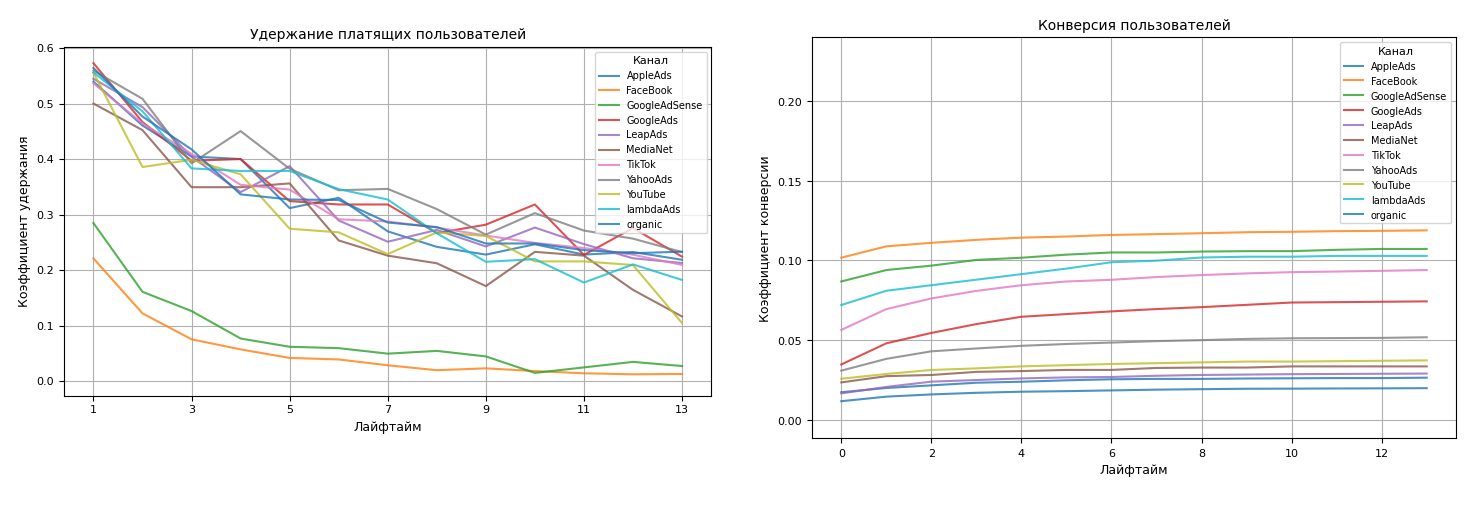

Лучший показатель удержания у платящих `органических` пользователей — $23.3\%$ — на них компания не потратила денег.\
В этом есть рациональное зерно, такие пользователи пришли сами, их никто не звал.

Но `органическим` пользователям наступают на пятки пользователи из других источников: `YahooAds`, `GoogleAds`, `AppleAds`, `LeapAds`.\
Все они остают не более чем на $2\%$ от `органических`.
 
Яркими же аутсайдерами являются пользователи из источников `GoogleAdSense` и `FaceBook`.\
Их удержание находится на уровне $2.7\%$ и $1.2\%$.


Лучше всех конвертируются в покупатели пользователи, которые пришли из каналов:
* `FaceBook` — $11.8\%$
* `GoogleAdSense` — $10.7\%$
* `lambdaAds` — $10.2\%$

Хуже всех:
* `organic` — $1.9\%$
* `AppleAds` — $2.6\%$
* `LeapAds` — $2.9\%$

Картина такая, что `органические` пользователи лучше всех удерживаются, но хуже всех конвертируются.\
А пользователи из `FaceBook` и `GoogleAdSense` наоборот — лучше всех конвертируются, но хуже всех удерживаются.

<br>

<br>

#### Юнит-экономика

<span style='font-weight: 600'>По всем пользователям</span>

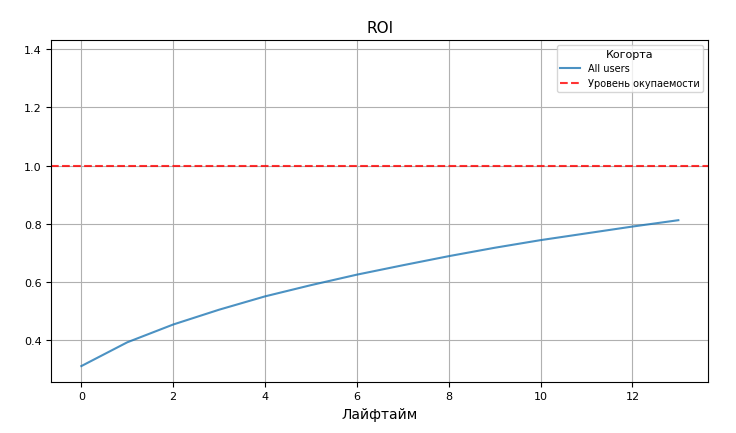

<span style='font-weight: 600'>`Органические` клиенты исключены из анализа:</span>

К концу второй недели <span style='font-weight: 600'>ROI</span> равен $81.1\%$.\
Реклама совсем не окупается, потому что с мая по октябрь <span style='font-weight: 600'>CAC</span> выросла с $0.74\$$ до $1.30\$$ за одного привлечённого пользователя, а <span style='font-weight: 600'>LTV</span> $14$-го дня топчется +/- на одном и том же месте, поэтому <span style='font-weight: 600'>ROI</span> опустился с окупаемых $137\%$ до печальных $66.5\%$. \
<span style='font-weight: 600'>CAC</span> растёт и <span style='font-weight: 600'>LTV</span> неизменный — <span style='font-weight: 600'>ROI</span> падает.

<br>

<br>

<span style='font-weight: 600'>По устройствам</span>

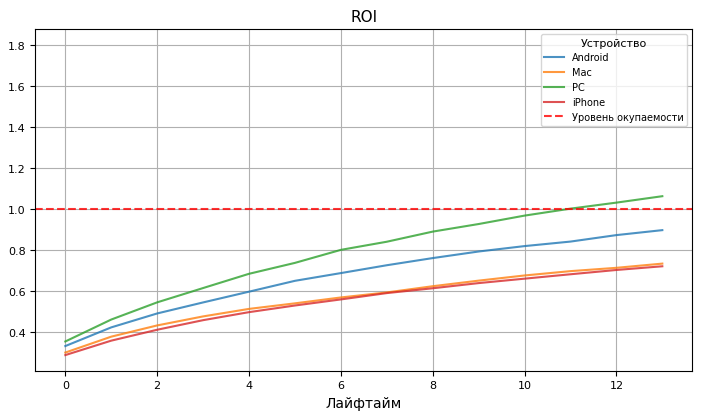

Только пользователи еле-еле `PC` окупаются, окупаться они начинают только с $12$-го дня, а их <span style='font-weight: 600'>ROI</span> на $14$-й день находится на отметке $106.3\%$.\
Пользователи `Android` и продукции `Apple` не окупаются, <span style='font-weight: 600'>ROI</span> пользователей `Android`, `iPhone` и `Mac` — $89.8\%$, $72.1\%$ и $73.4\%$, несмотря на то, что <span style='font-weight: 600'>LTV</span> этих трёх когорт выше <span style='font-weight: 600'>LTV</span> `PC`.

Динамика <span style='font-weight: 600'>ROI</span> сказала, что окупаемость по всем устройствам с каждым месяцем становится всё хуже и хуже.\
С каждым месяцем <span style='font-weight: 600'>CAC</span> растёт всё больше и больше.

<br>

<br>

<span style='font-weight: 600'>По странам</span>

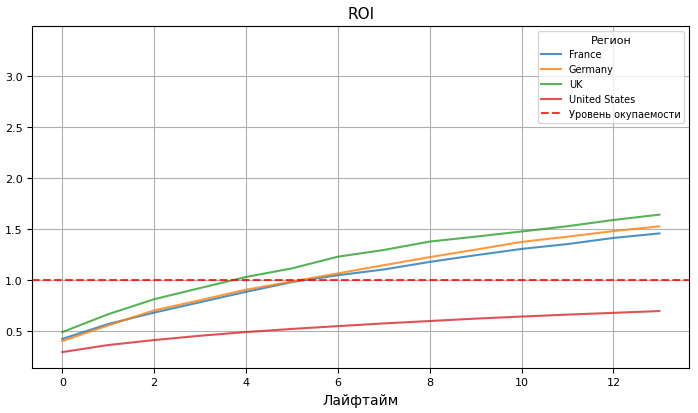

Пользователи из `США` приносят больше всех дохода, но они совсем не окупаются, потому что очень дорого стоят.\
В них вся проблема. Нужно изучить этот регион подробнее.

А вот люди из `Великобритании` самые прибыльные.\
`Немцы` и `французы` тоже хорошо окупаются.

Средний рейтинг окупаемости регионов по состоянию на $14$-й день:
1. Великобритания — $164\%$
2. Германия — $152\%$
3. Франция — $145\%$
4. США — $69.2\%$

<br>

<br>

<span style='font-weight: 600'>По каналам</span>

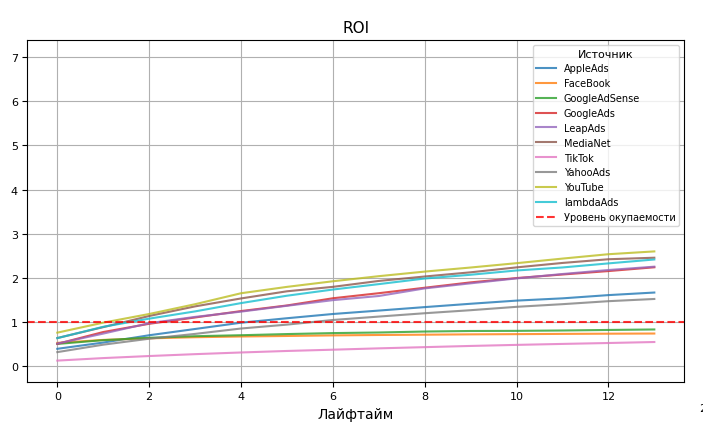

Выделились самые доходные пользователи, с самым высоким <span style='font-weight: 600'>LTV</span>:
1. `lambdaAds` — $1.75$ $\$$
2. `TikTok` — $1.49$ $\$$

Следующие каналы привлечения не окупились, потому что их <span style='font-weight: 600'>ROI</span> ниже $100\%$:
1. `TikTok` — $54.5\%$
2. `FaceBook` — $73.7\%$
3. `GoogleAdSense` — $82.9\%$

Самый окупаемый канал — `YouTube` с <span style='font-weight: 600'>ROI</span> $259.7\%$

Самым затратным каналом оказался `TikTok`, на графике динамики <span style='font-weight: 600'>CAC</span> он сильно выделился, потому что стоимость пользователя подскочила с $1$ $\$$ до $3.58$ $\$$, в то время как по остальным каналом максимальная стоимость чуть-чуть превышает $1$ $\$$.

<br>

<br>

#### Окупаем рекламу

Итак, реклама, направленная на привлечение пользователей, в целом не окупается, потому что <span style='font-weight: 600'>ROI</span> находится на отметке в $81.1\%$

Пользователи следующих когорт не окупаются, их <span style='font-weight: 600'>ROI</span> меньше $100\%$:
1. обладатели устройств `iPhone`, `Mac`, `Android`;
2. пользователи из `США`;
3. привлечённые из каналов `TikTok`, `GoogleAdSense`, `FaceBook`.

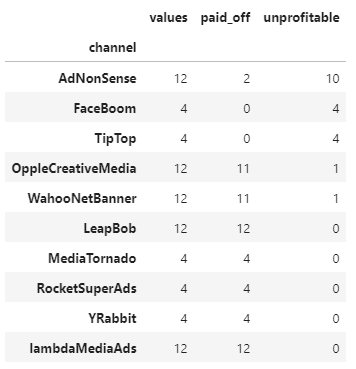

Встречаются $5$ рекламных источников, которые не окупались.\
В случае $3$-х из них ситуация очень плохая:
* Источники `FaceBook` и `TikTok` никогда не окупались;
* `GoogleAdSense` не окупался в $10$ из $12$ случаев.

Именно в этих трёх каналах пользователи и не окупались.\
С ними нужно работать.

Среди всех пользователей, привлечённых из `США`, $44$ $689$ человек, что составляет $78,6\%$ от общего числа пользователей из `США`, пришли через убыточные каналы `FaceBook` и `TikTok`.\
В `Европе` убыточный канал `GoogleAdSense` привлёк столько пользователей:
* В `Великобритании` — $1$ $207$ юзеров, $11.8\%$ от всех из `Великобритании`;
* Во `Франции` — $1$ $284$ юзера, $12.6\%$ от всех из `Франции`;
* В `Германии` — $1$ $136$ юзеров, $12.9\%$ от всех из `Германии`.

Выходит, мы имеем $48$ $316$ пользователей из убыточных каналов, это $56.1\%$ из $86$ $138$ привлечённых.\
Получается, что в окупающихся каналах содержится $37$ $822$ $(43.9\%)$ пользователя.

<br>

$86$ $138$ пользователей за $14$ дней существования принесли $77$ $793$ $\$$, но на них было затрачено $95$ $806$ $\$$.\
Следовательно, на $14$-й день жизни всех когорт мы в минусе на $18$ $013$ $\$$.

<br>

Если из рассчёта юнит-экономики вырезать убыточные каналы `FaceBook`, `TikTok`, `GoogleAdSense`, то ситуация сильно изменится.

Общий <span style='font-weight: 600'>ROI</span>, <span style='font-weight: 600'>ROI</span> в разбивке по устройствам, странам, каналам без этих каналов выглядит так.

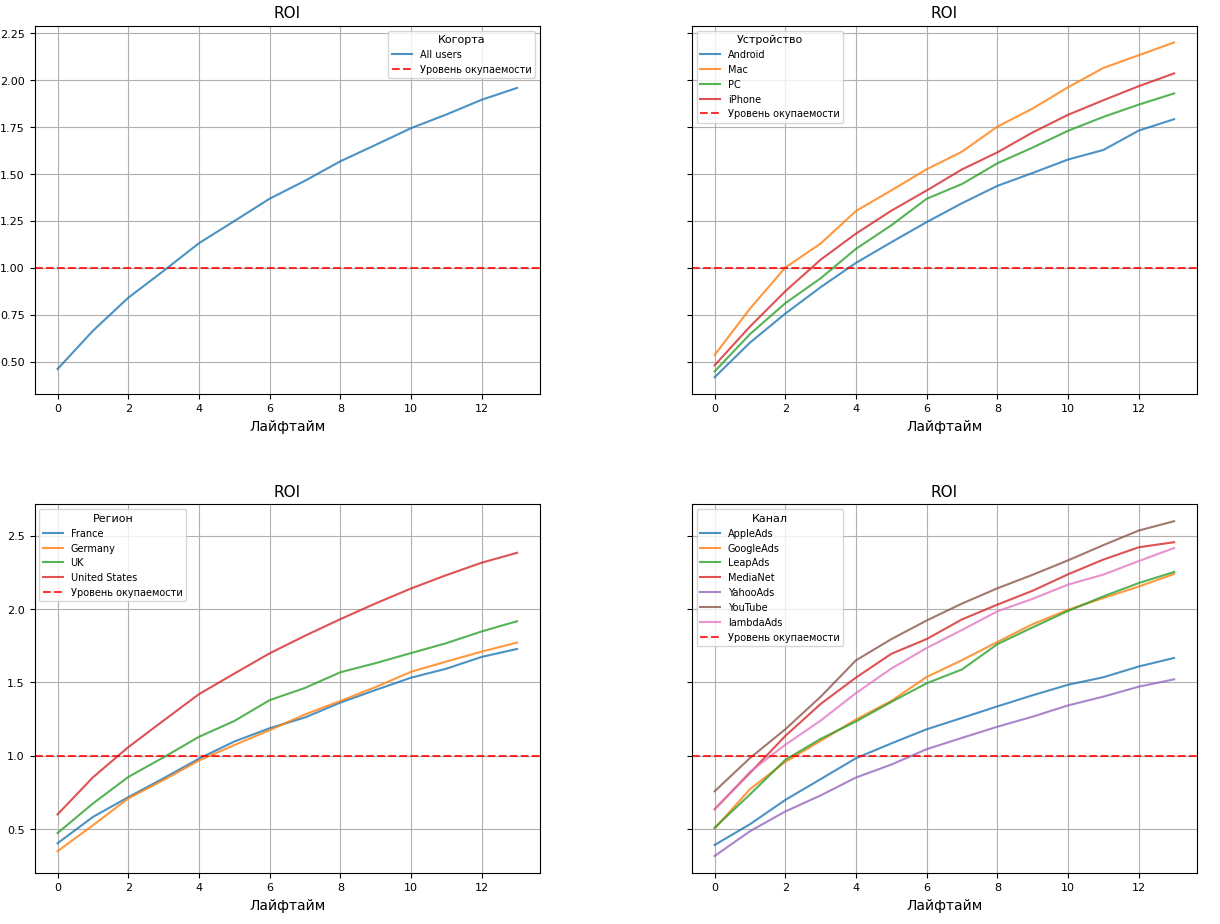

Генеральный <span style='font-weight: 600'>ROI</span>, на первом графике, равен $195\%$. Теперь реклама полностью окупается и приносит прибыль.\
Также по всем устройствам, регионам, каналам реклама приносит прибыль.

<br>

$37$ $822$ пользователя из $7$ прибыльных каналов за $14$ дней существования принесли $26$ $043$ $\$$, и на них было затрачено $13$ $301$ $\$$.\
Следовательно, на $14$-й день жизни всех когорт мы в плюсе на $12$ $742$ $\$$.

<br>

<span style='font-weight: 600'>Итоги.</span>\
Причины неэффективности привлечения пользователей кроются в каналах `FaceBook` и `TikTok` для `США` и `GoogleAdSense` для `Европы`.\
Глобальная рекомендация для отдела маркетинга — нужно:
1. для `США`:
    1. перестать закупать трафик из каналов `FaceBook` и `TikTok`;
    2. начать привлекать пользователей из каналов `MediaNet`, `YouTube`, `GoogleAds`.
2. для `Европы`:
    1. перестать закупать трафик из канала `GoogleAdSense`;
    2. начать привлекать пользователей из каналов `LeapAds`, `AppleAds`, `YahooAds`, `lambdaAds`.